In [9]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm

# setting things up:

In [10]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
output_path = path / "Output"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"

In [11]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [12]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [13]:
def plot_hydrograph(ds_combined, ax):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [14]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        for j in range(n_particles):
            axs[i+1].fill_between(ds_combined.time, 
                             ds_combined[var].sel(summary_stat="min").values,
                             ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
            axs[i+1].set_title(var_names[var])
            axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

# Loading files

In [17]:
from pathlib import PosixPath

import paths from 39.2

In [18]:
paths = [PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01022500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 14_02.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01013500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 12_47.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01073000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 00_07.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01162500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 12_45.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01078000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 01_23.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01031500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 16_33.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01142500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 10_13.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01057000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 22_51.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01144000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 11_29.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01118300_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 02_38.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01139000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 07_42.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01139800_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 08_58.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01170100_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 15_16.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01047000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 17_49.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01134500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 11_31.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01169000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 14_01.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01181000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 16_32.nc')]

In [20]:
lst_ds = []
for path in paths:
    ds = xr.open_dataset(path)
    lst_ds.append(ds)

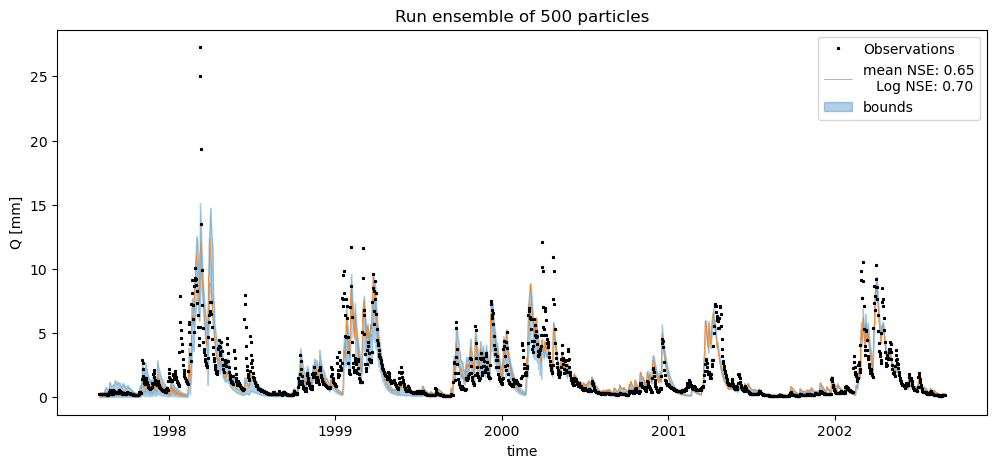

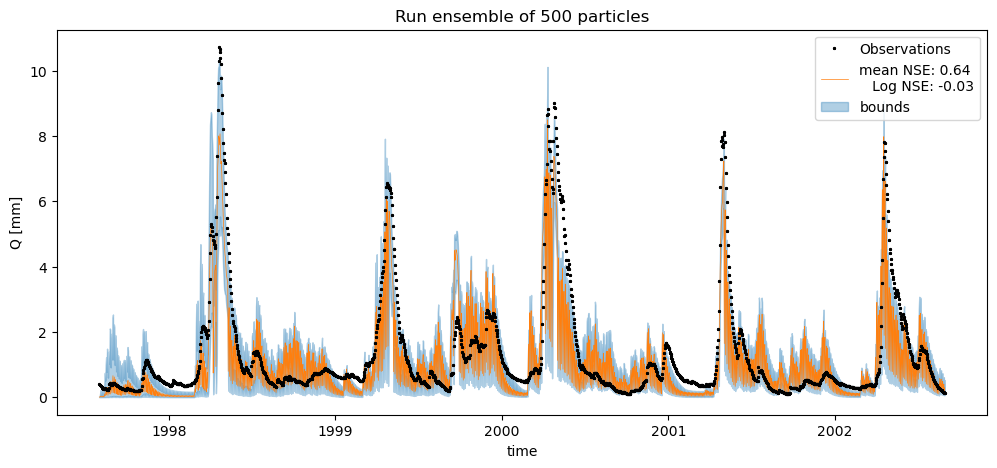

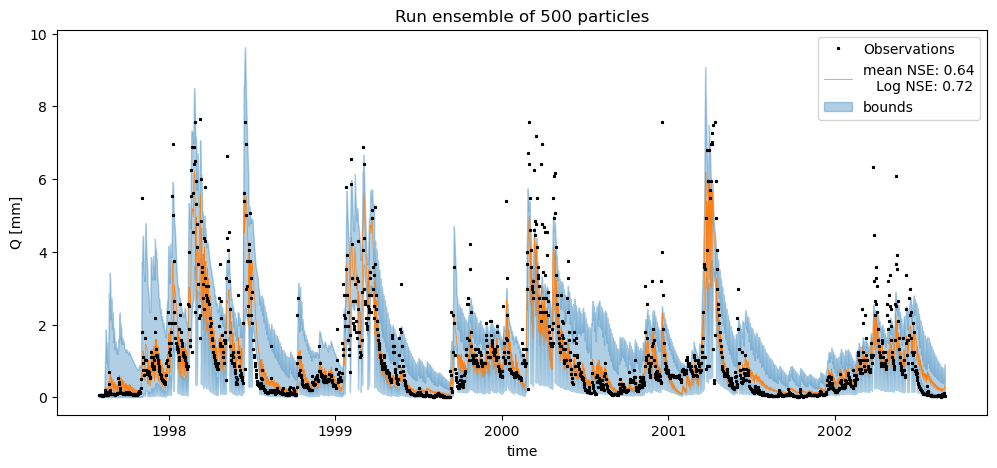

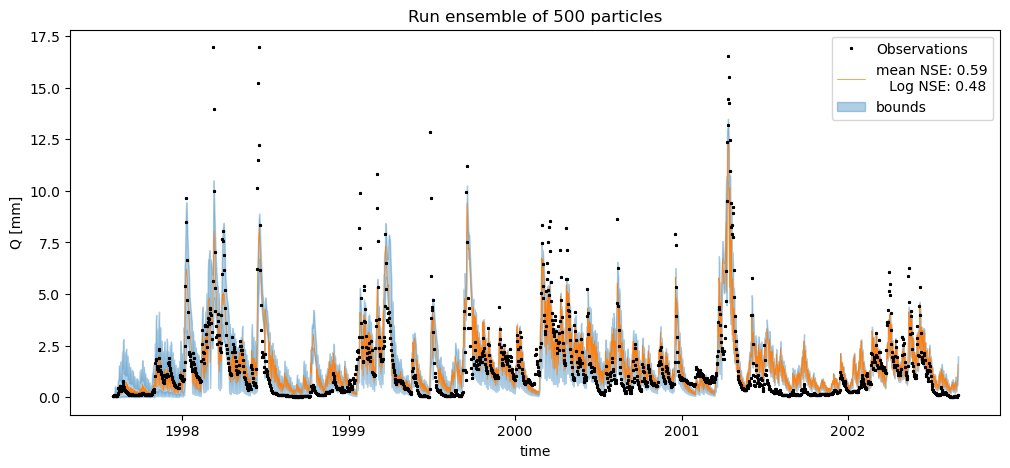

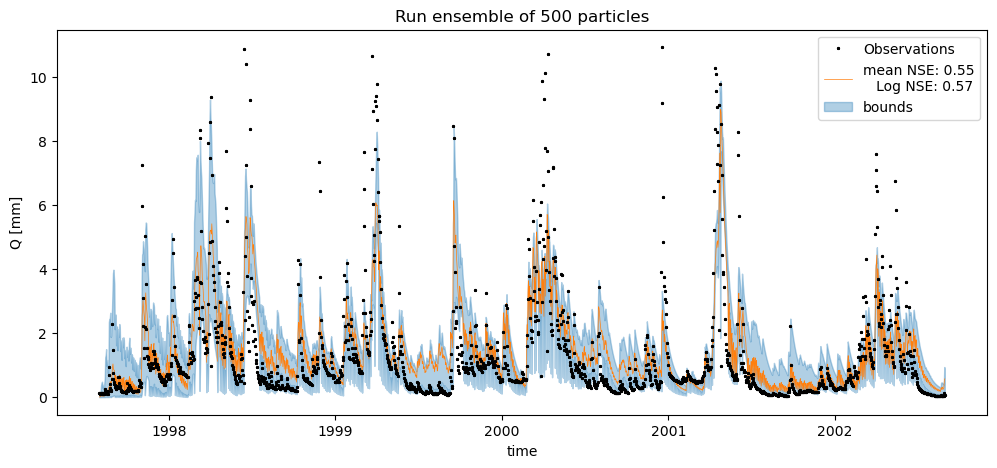

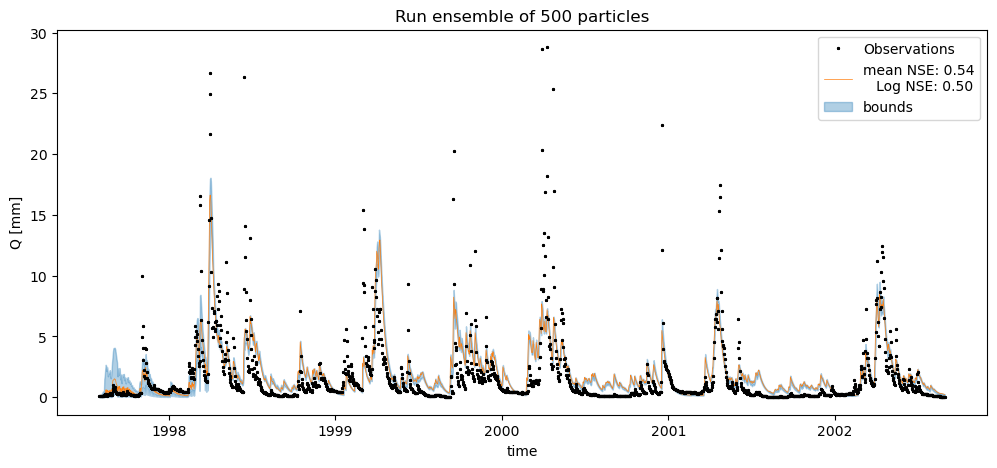

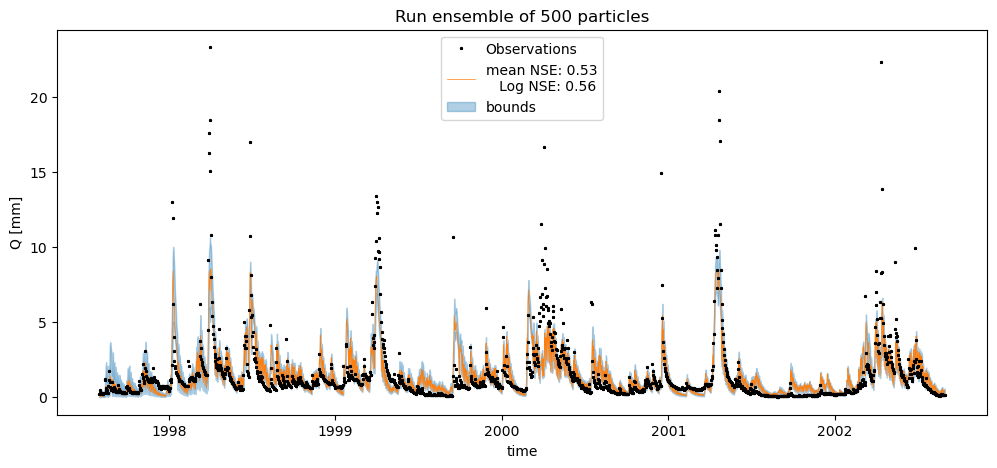

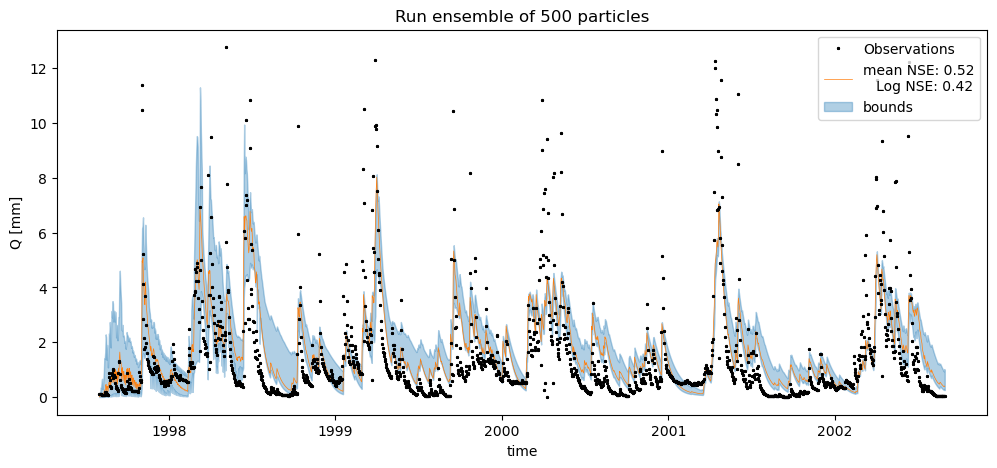

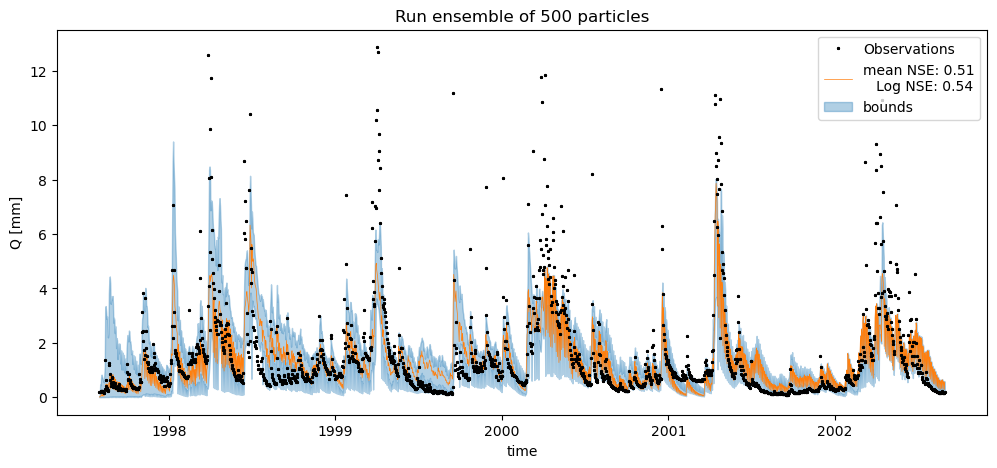

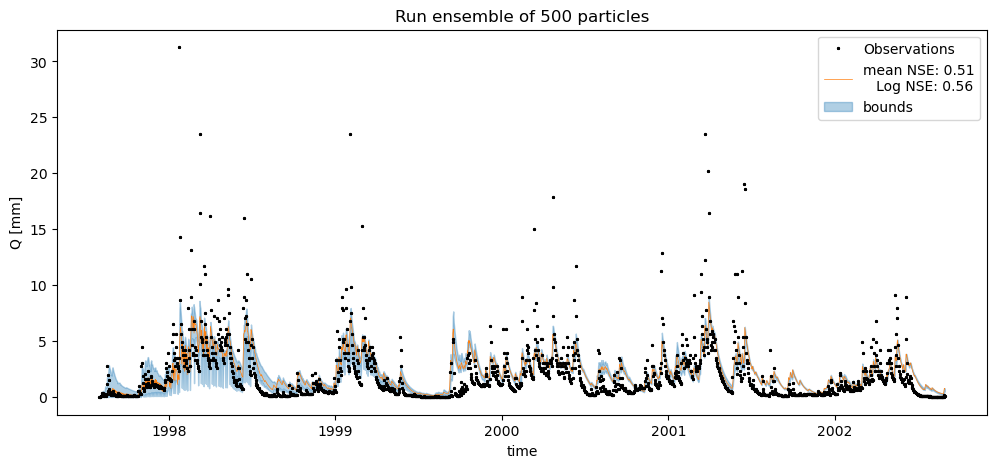

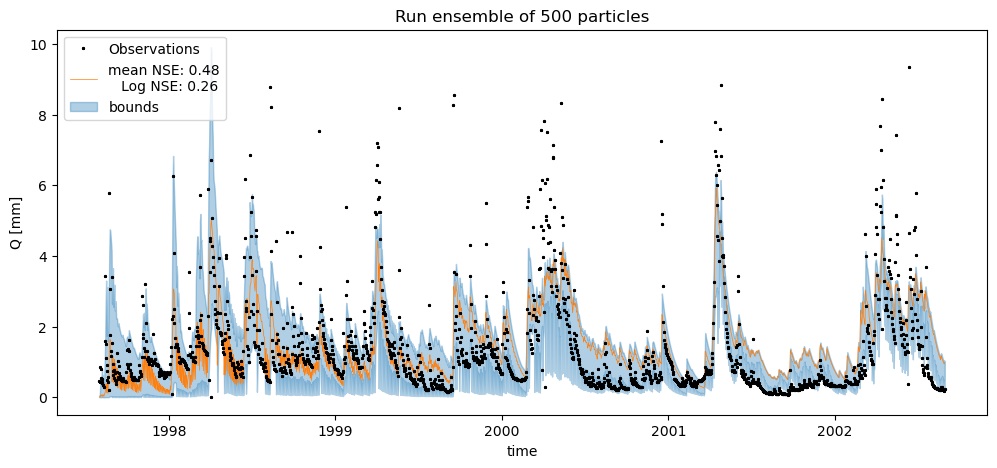

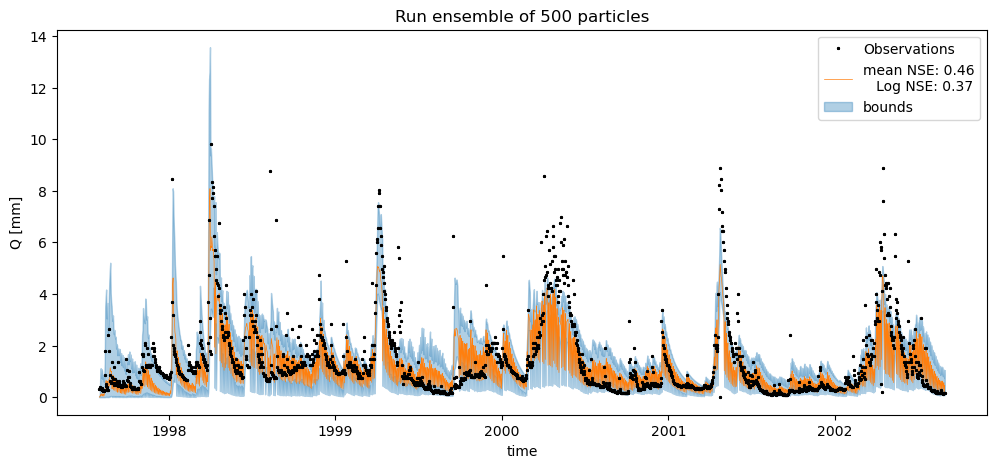

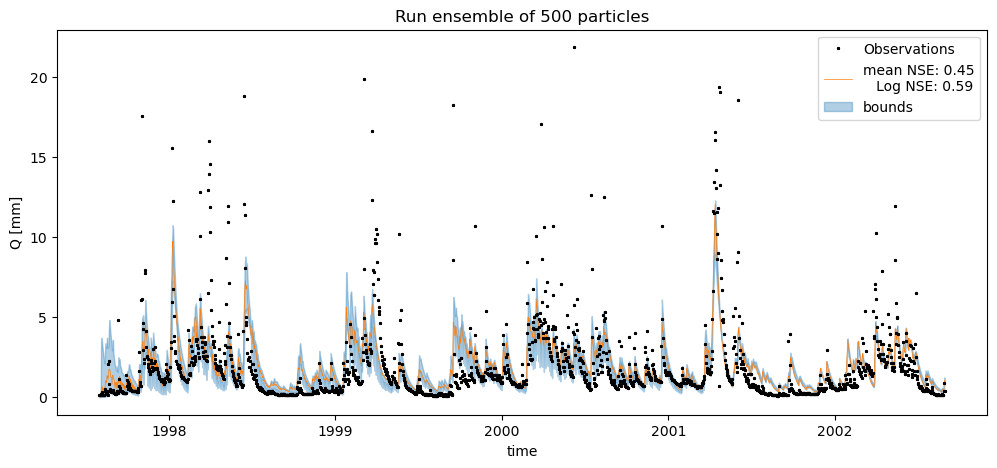

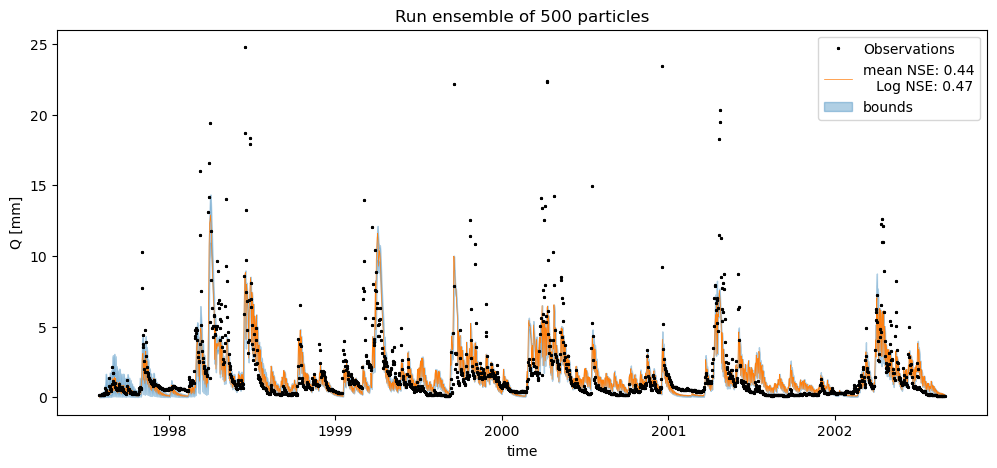

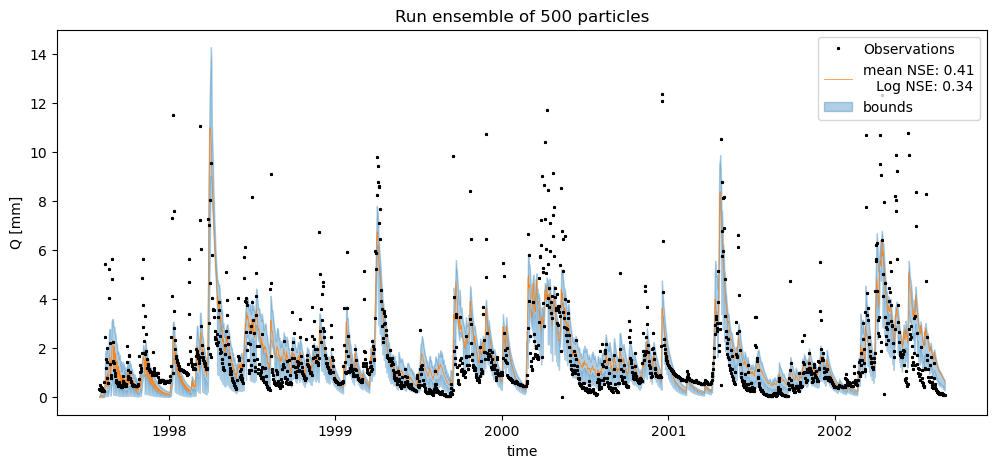

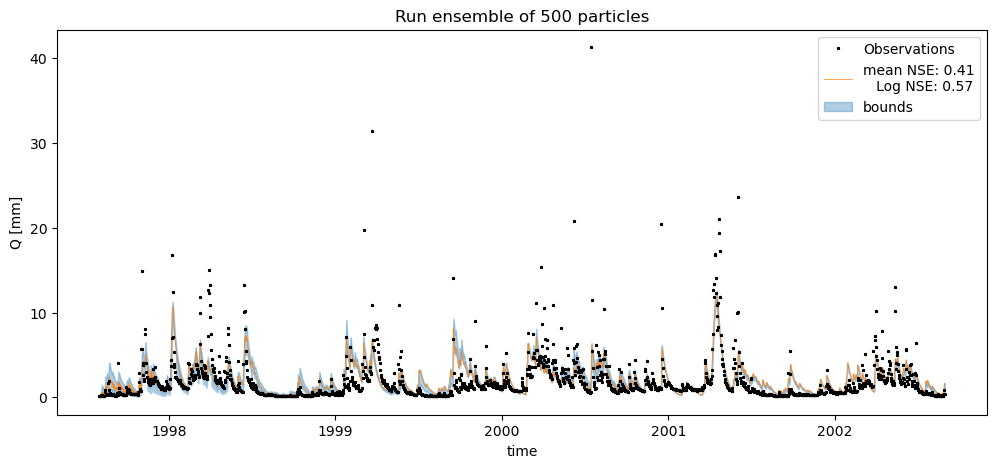

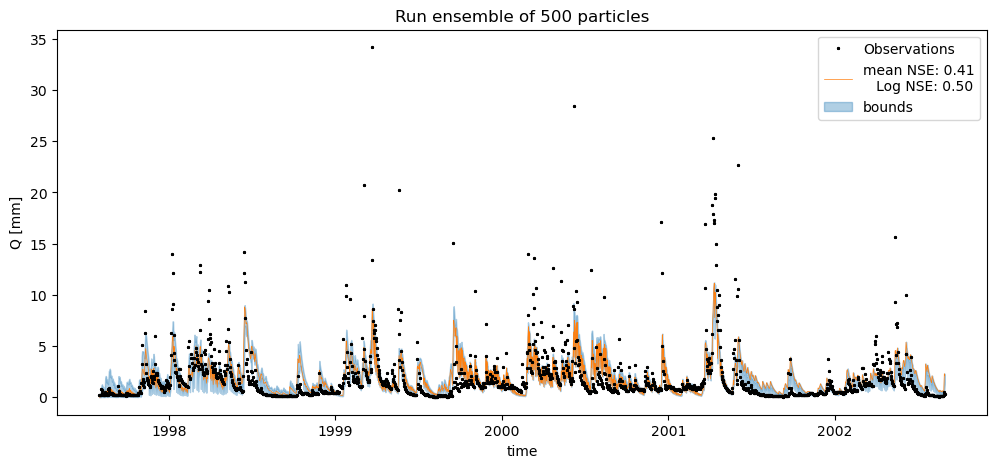

In [31]:
for i in range(len(lst_ds)):
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    plot_hydrograph(lst_ds[i], ax)
    ax.legend()

In [23]:
len(lst_ds)

17

# individual:

## 0

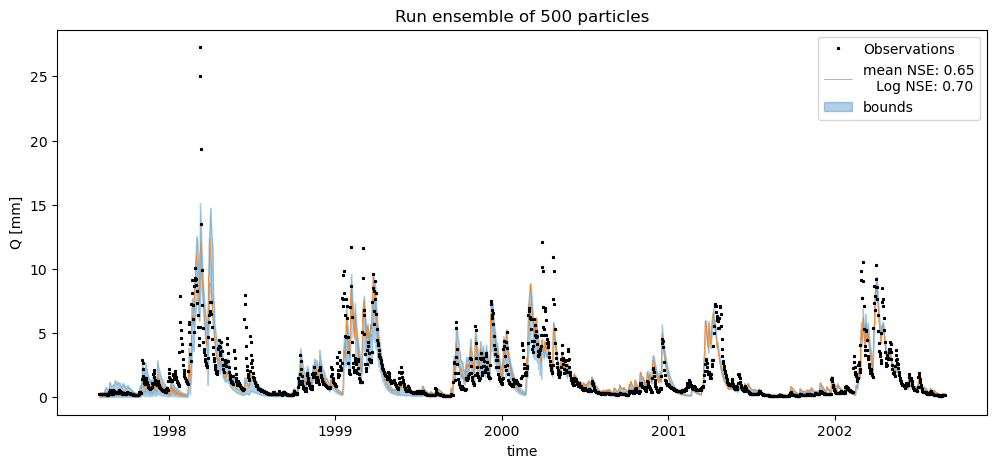

In [39]:
i=0
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

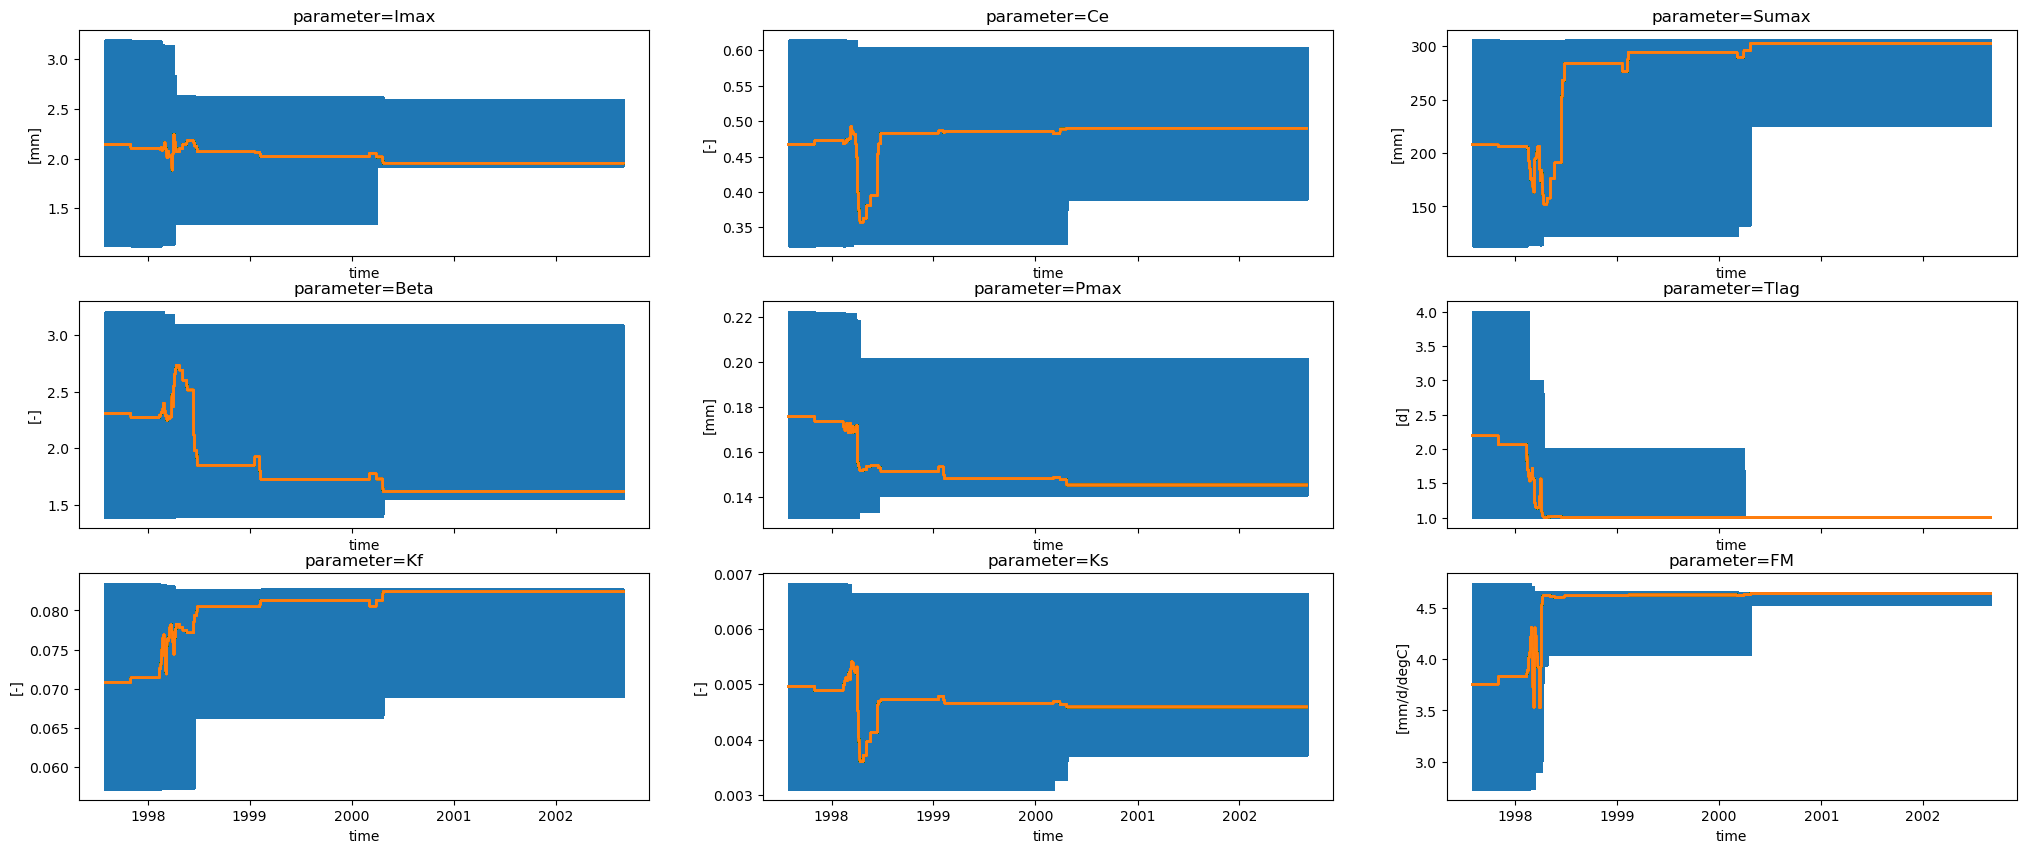

In [40]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

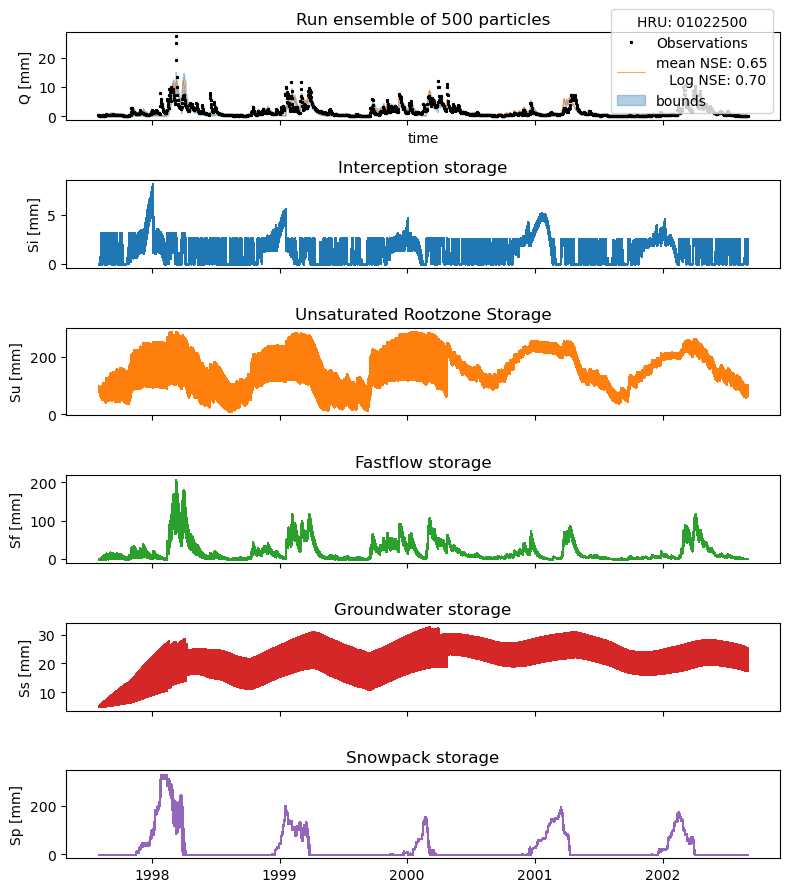

In [41]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 1

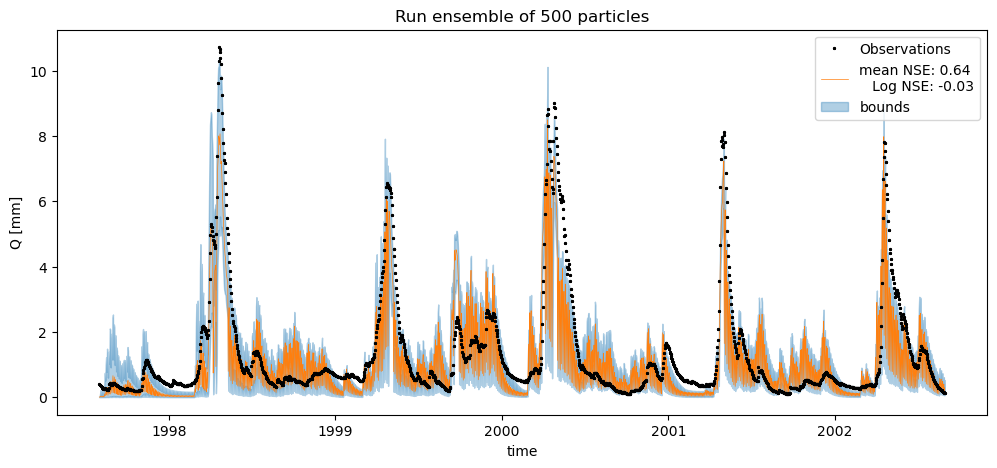

In [36]:
i=1
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

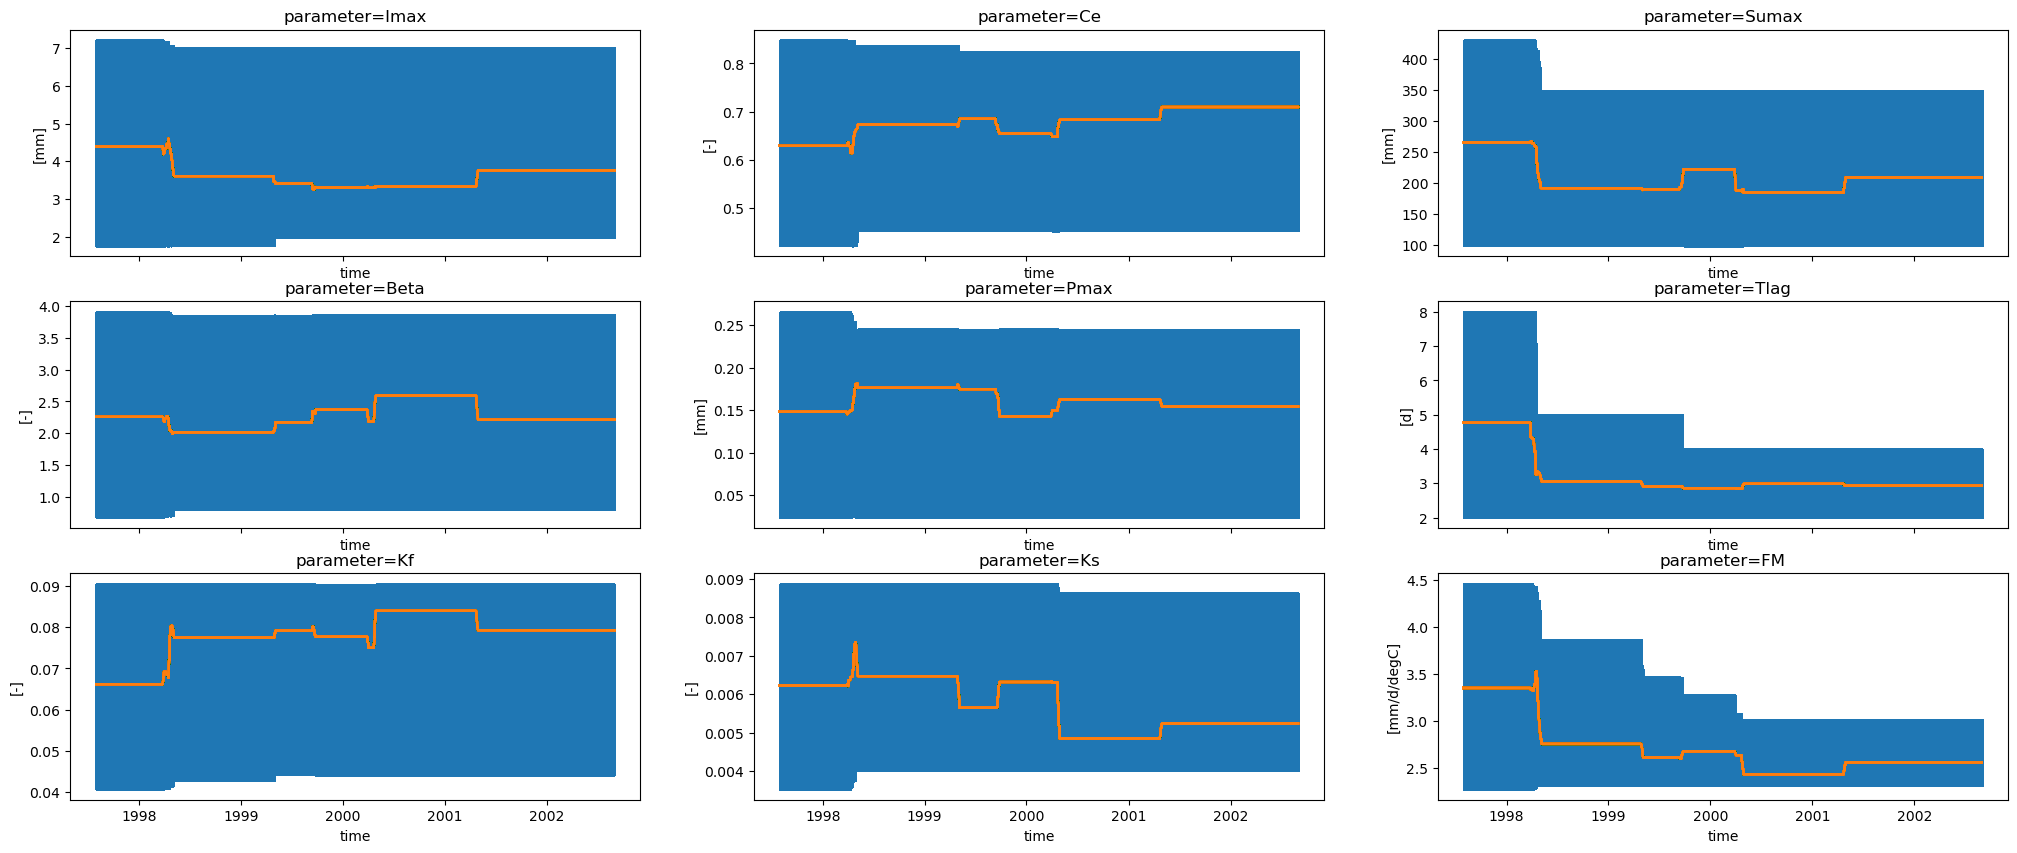

In [37]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

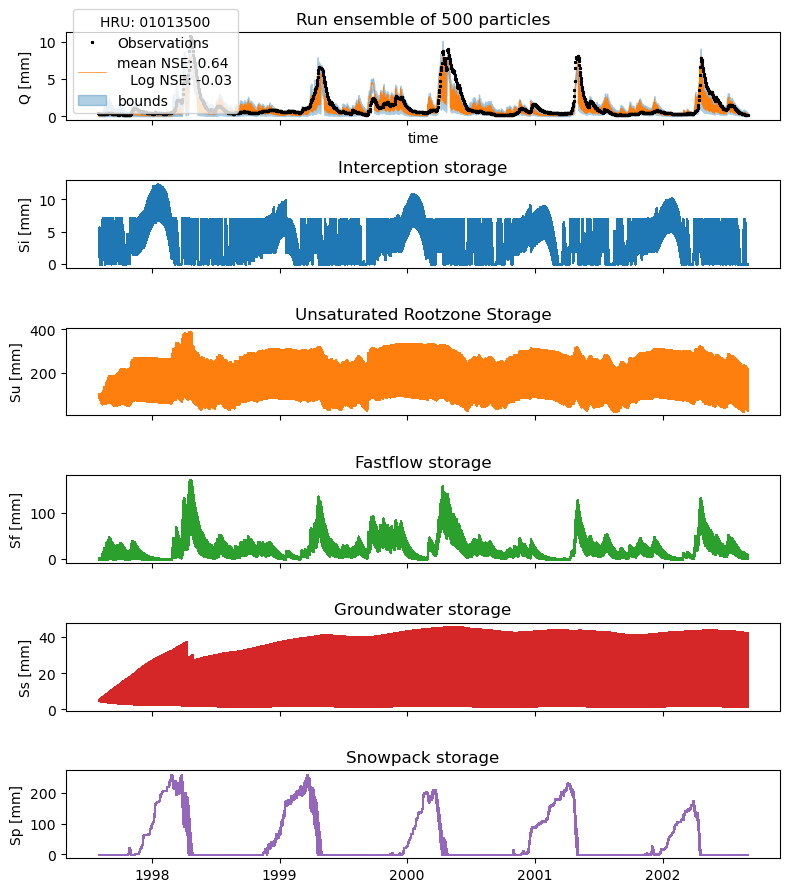

In [38]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 2 

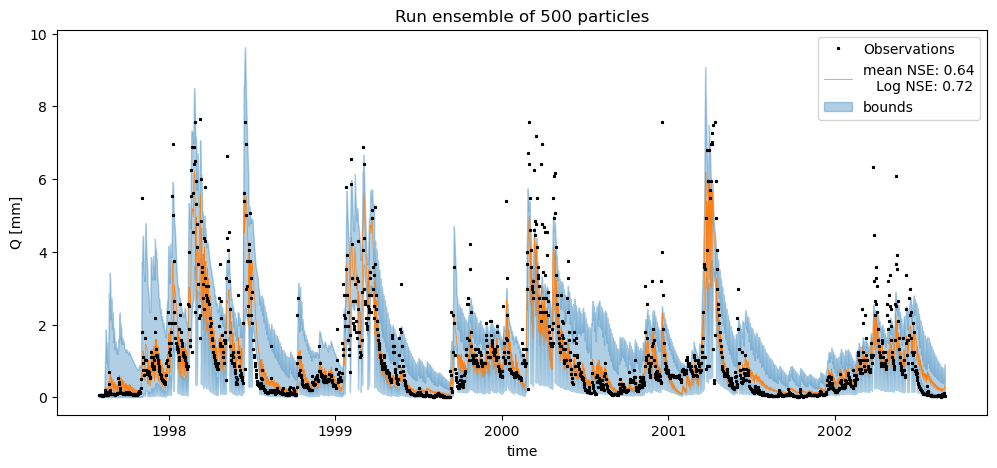

In [44]:
i=2
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

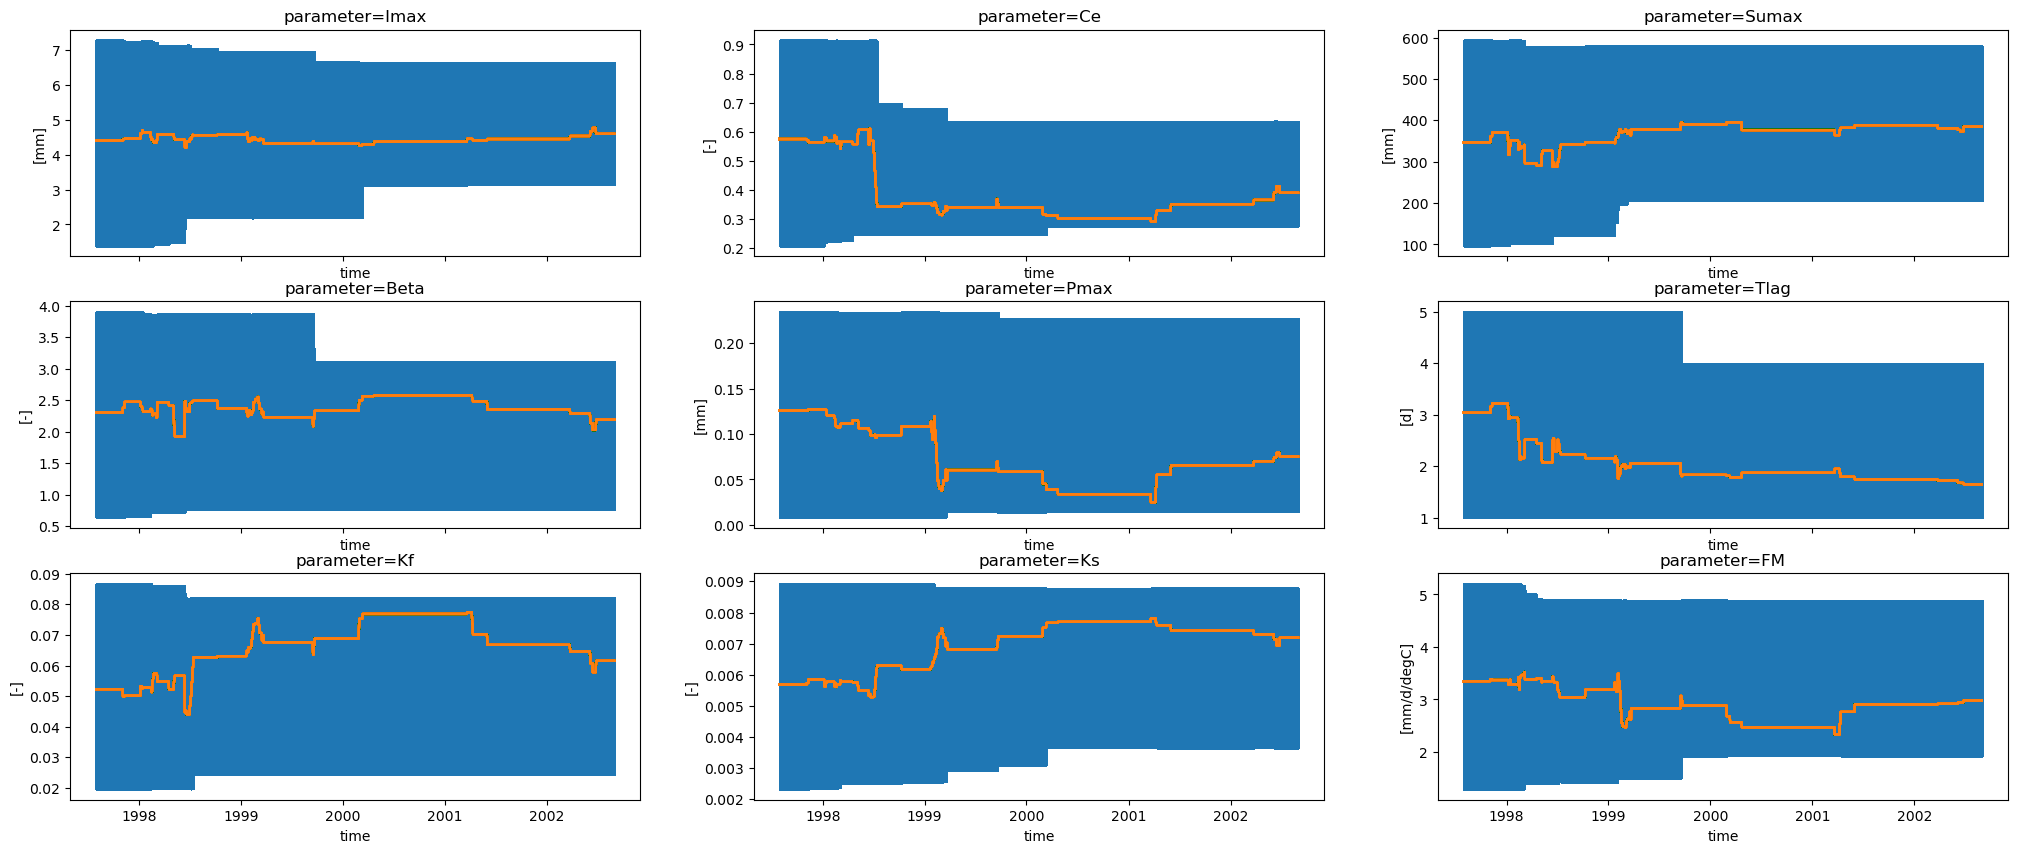

In [45]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

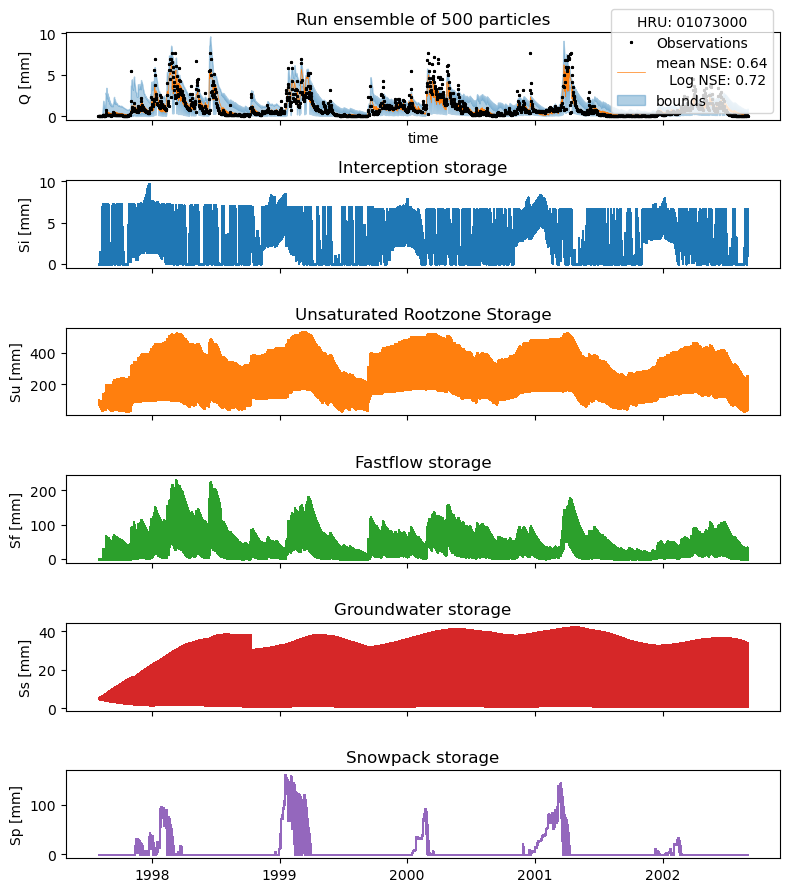

In [46]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 3

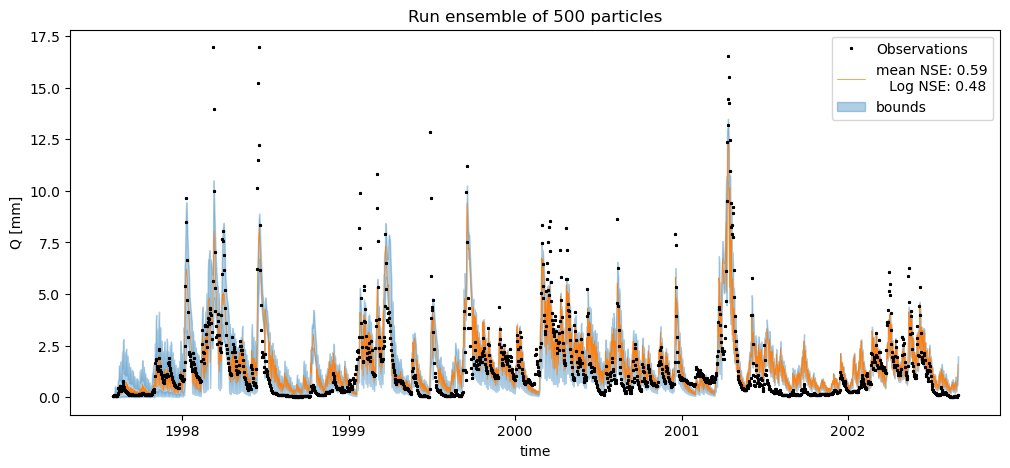

In [47]:
i=3
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

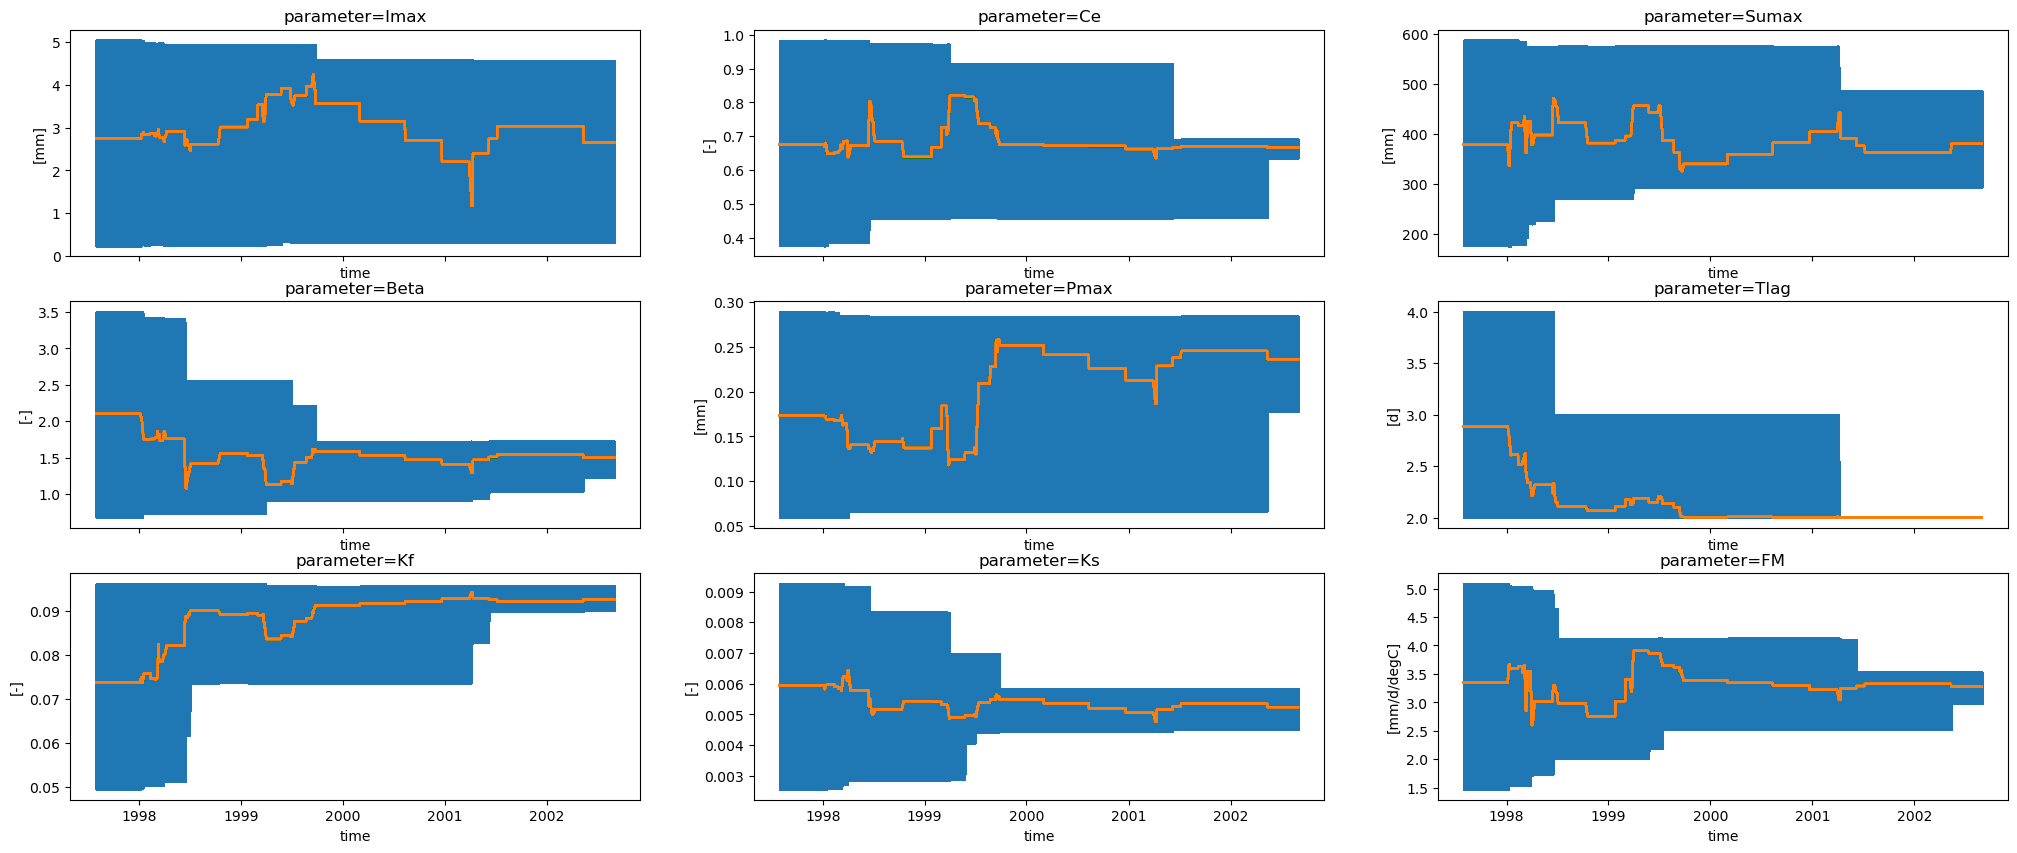

In [48]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

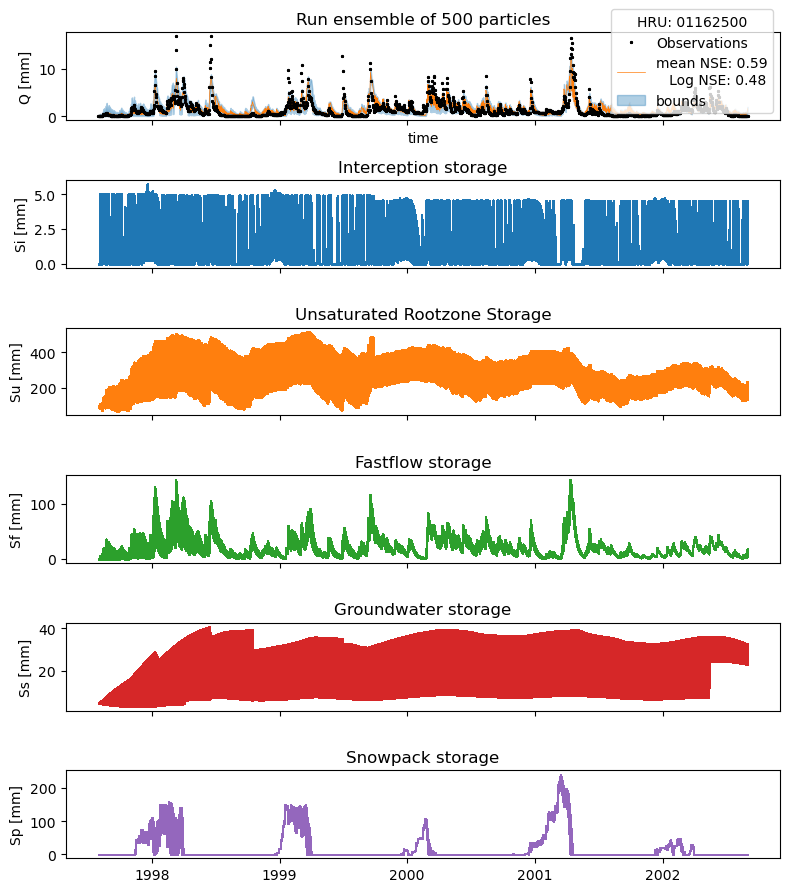

In [49]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 4

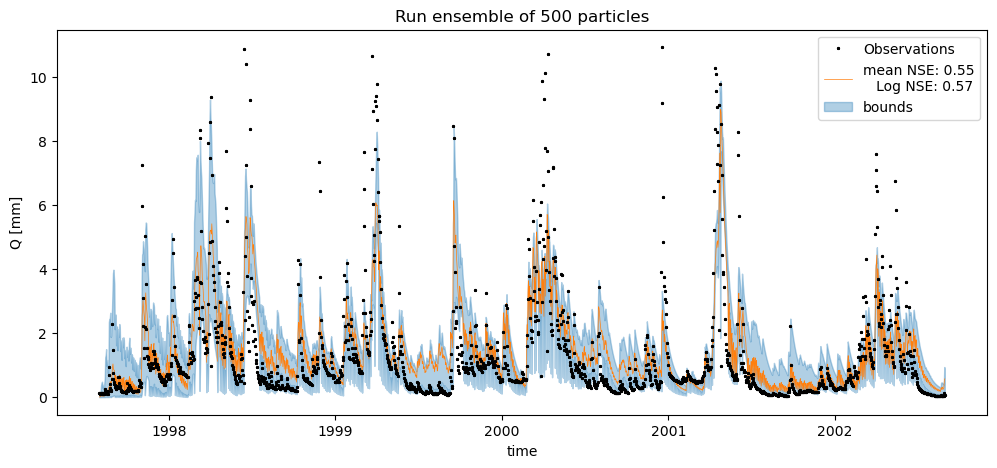

In [50]:
i=4
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

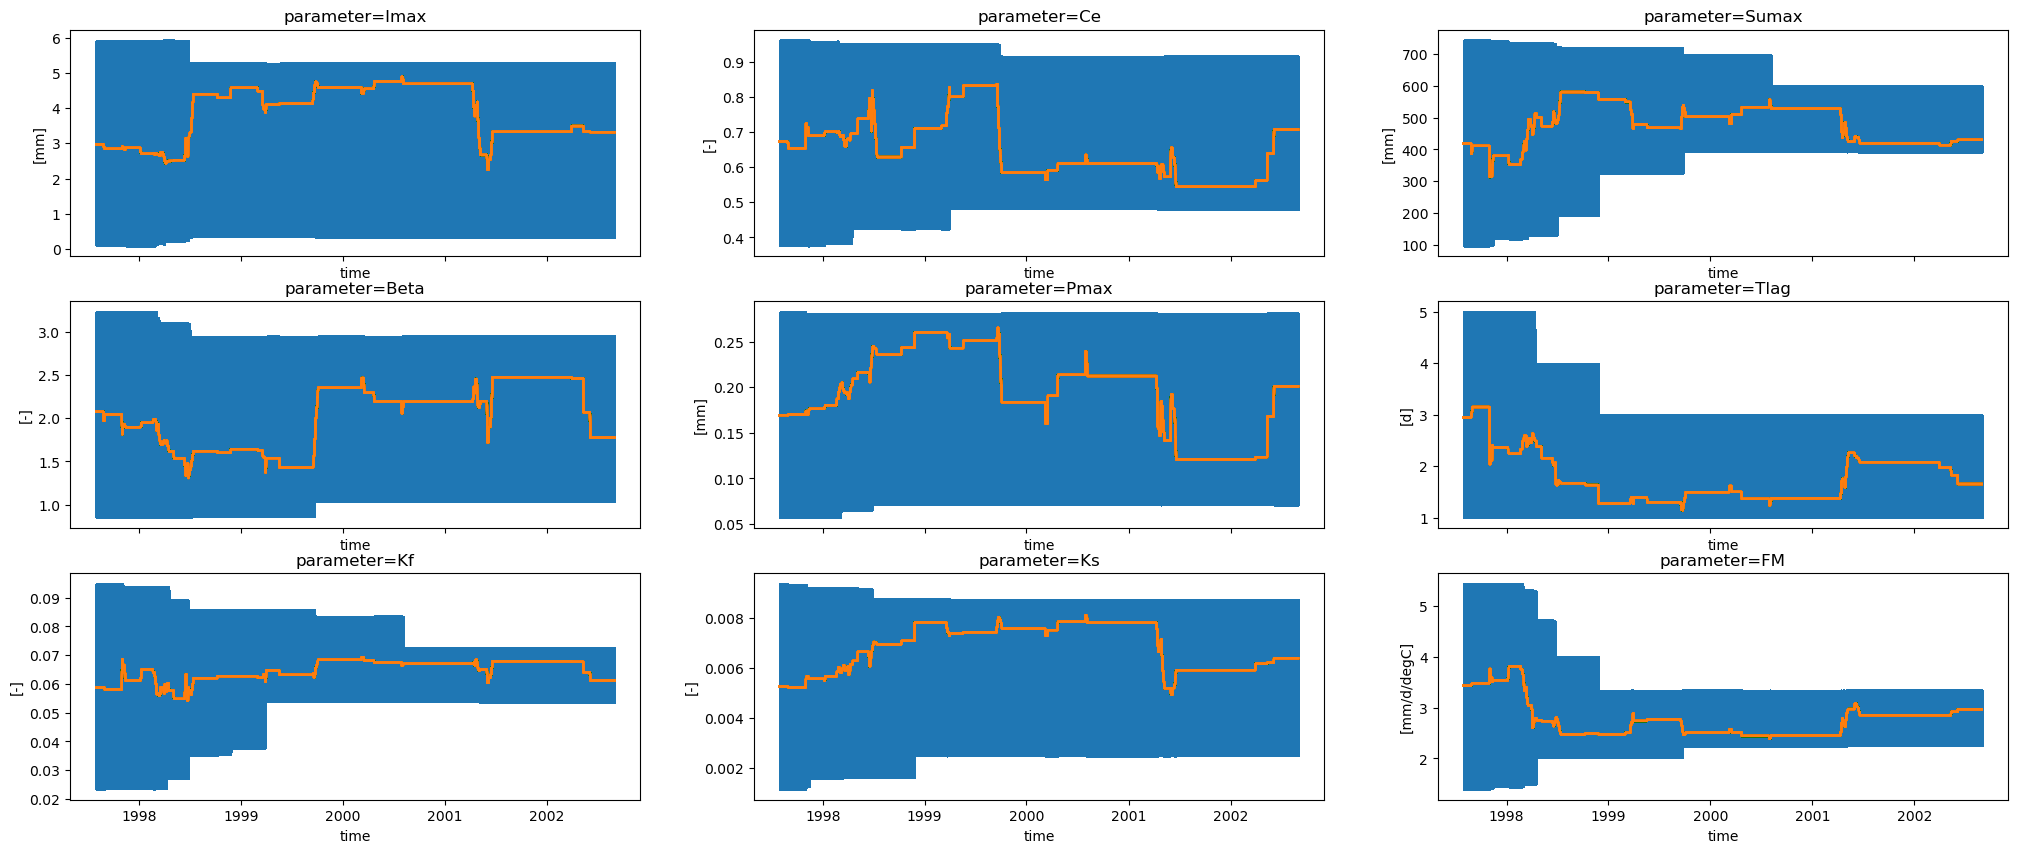

In [51]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

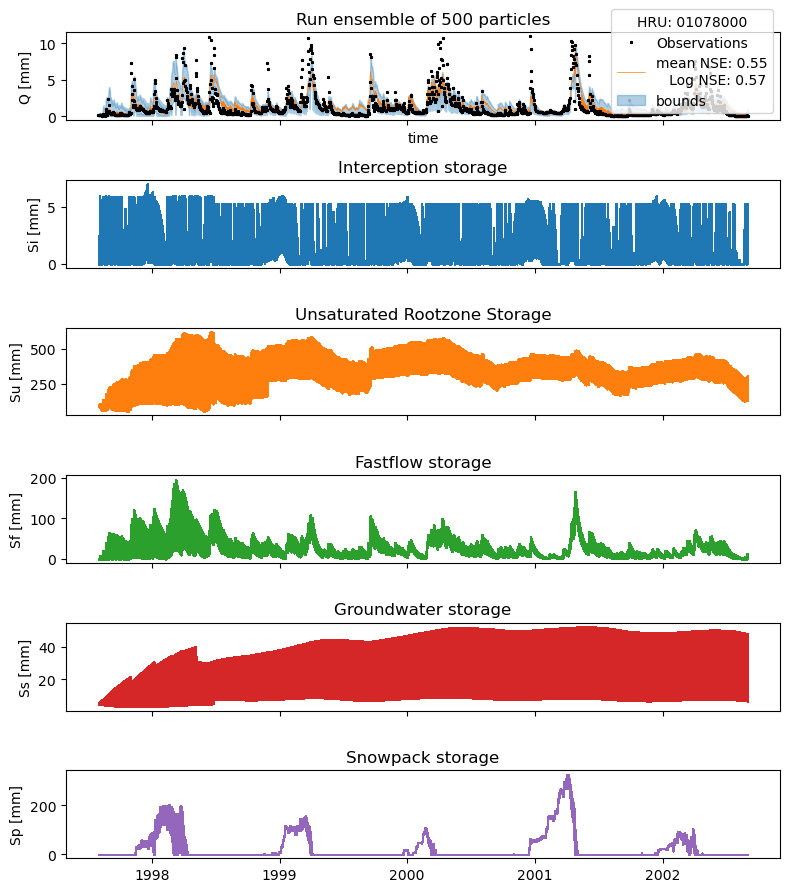

In [52]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 5

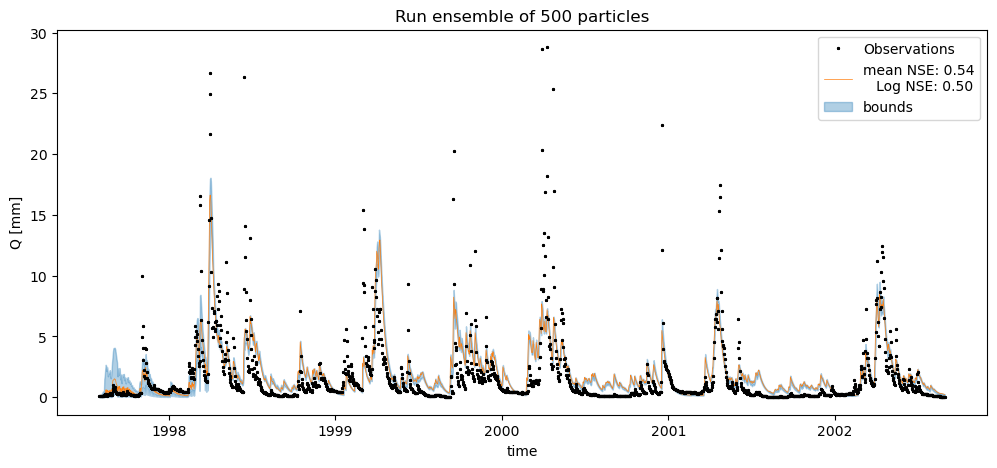

In [54]:
i=5
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

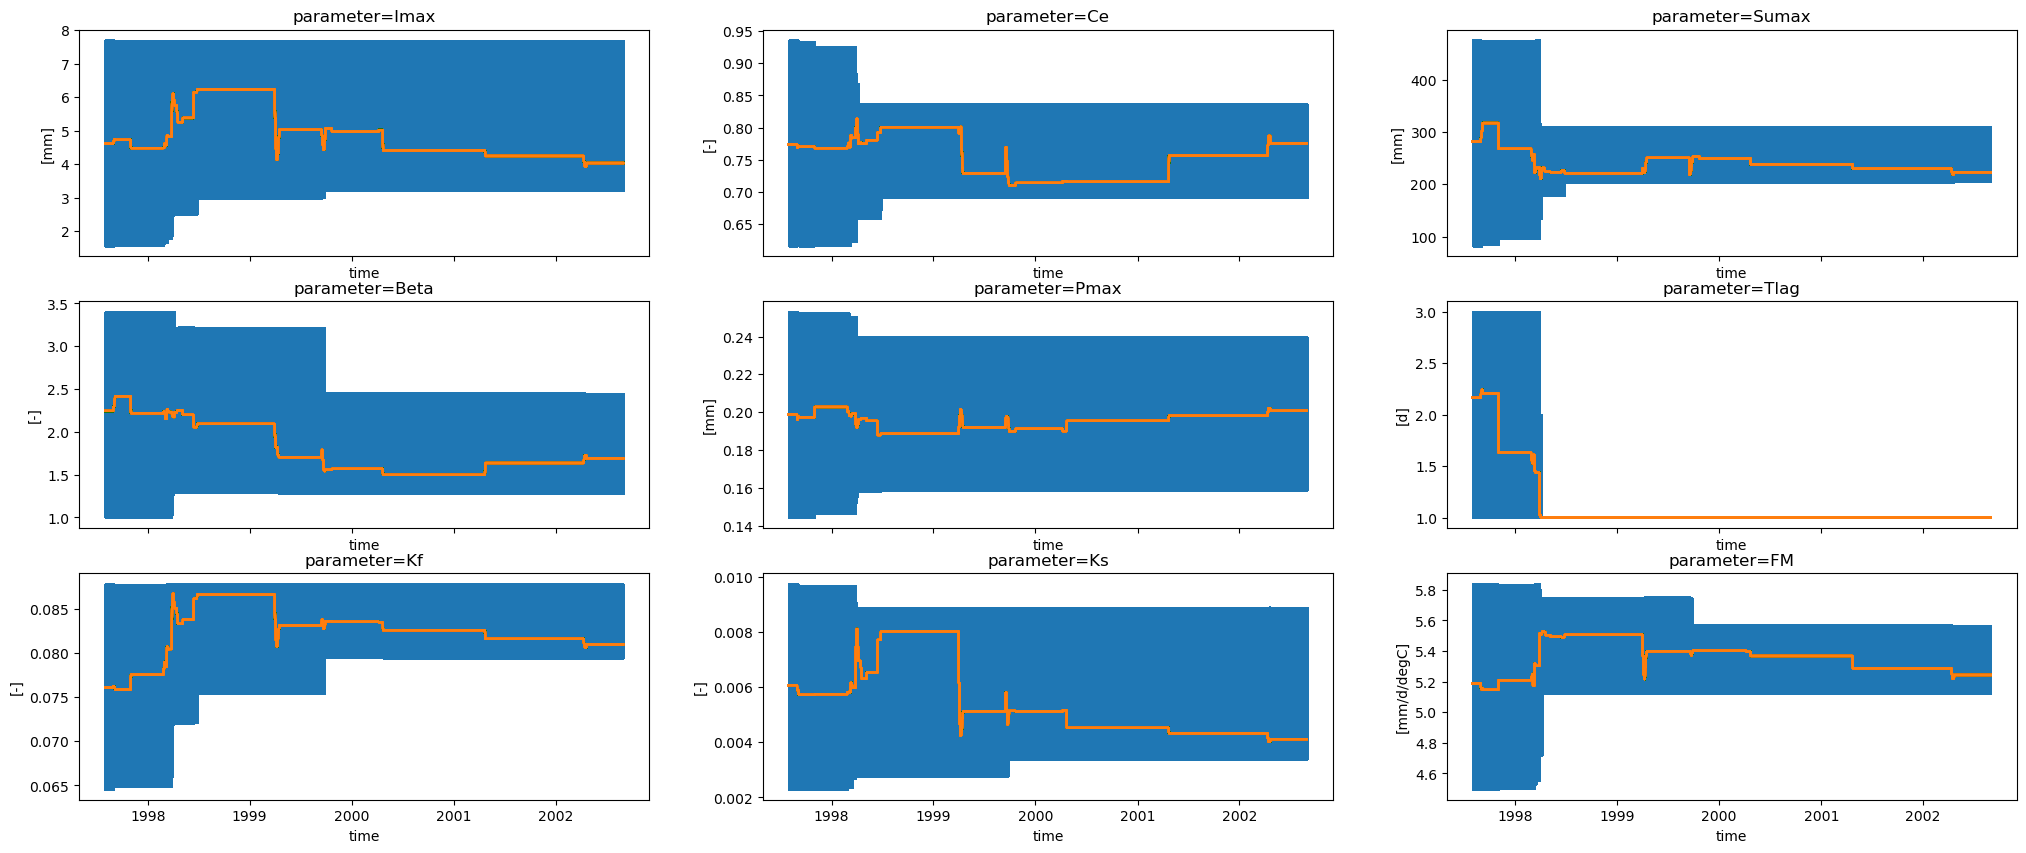

In [55]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

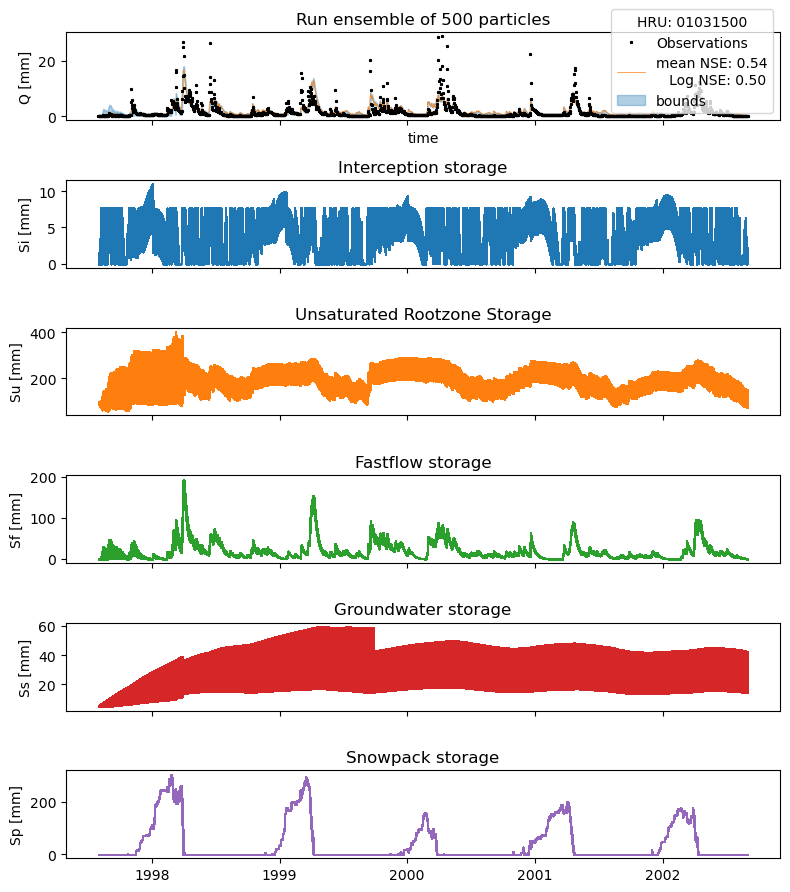

In [56]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 6

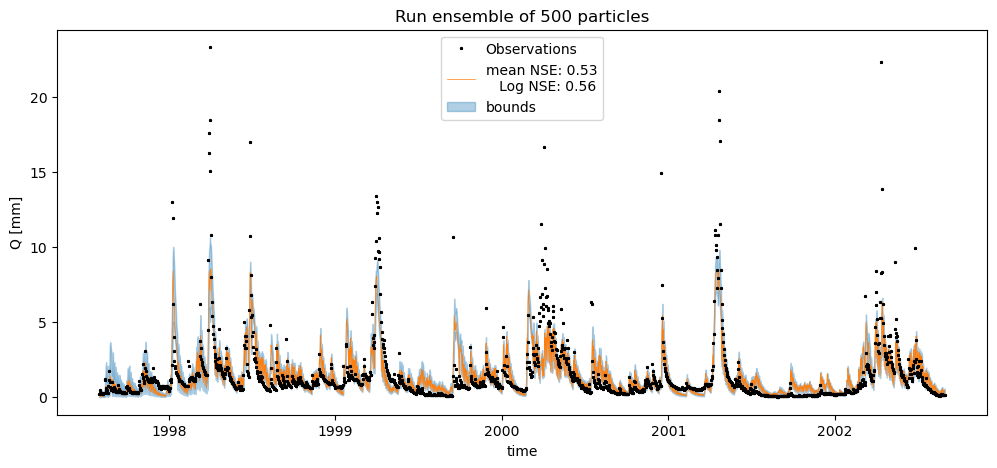

In [57]:
i=6
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

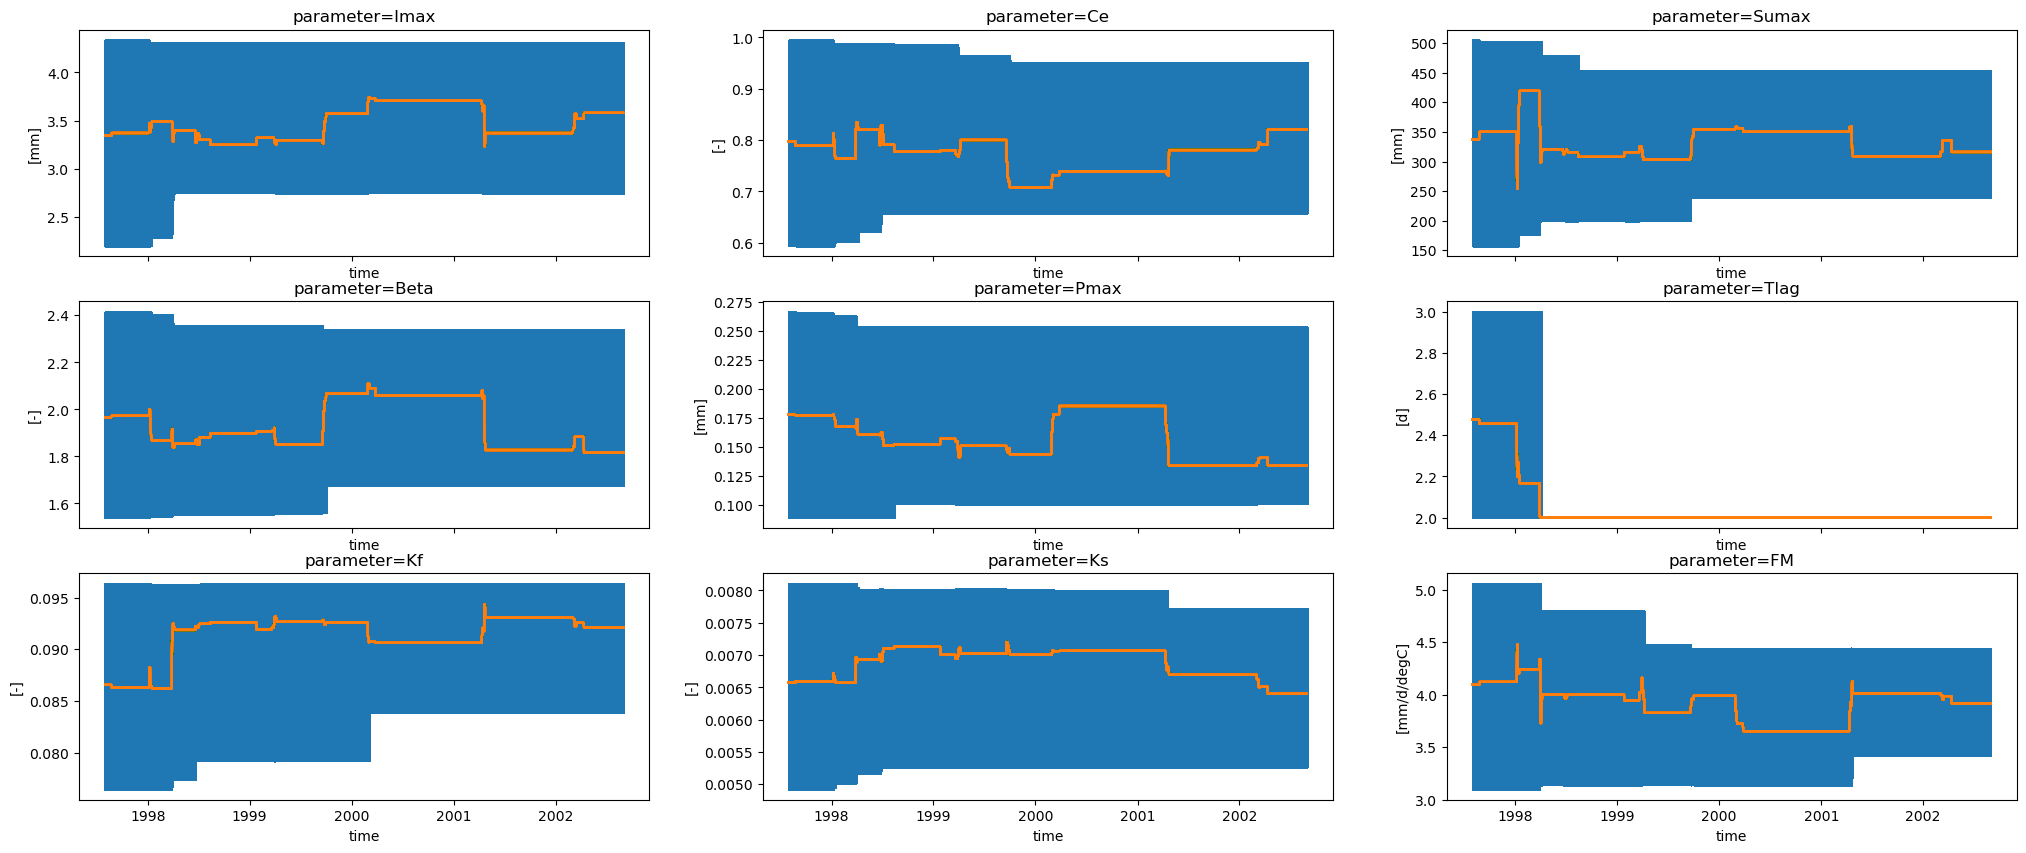

In [58]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

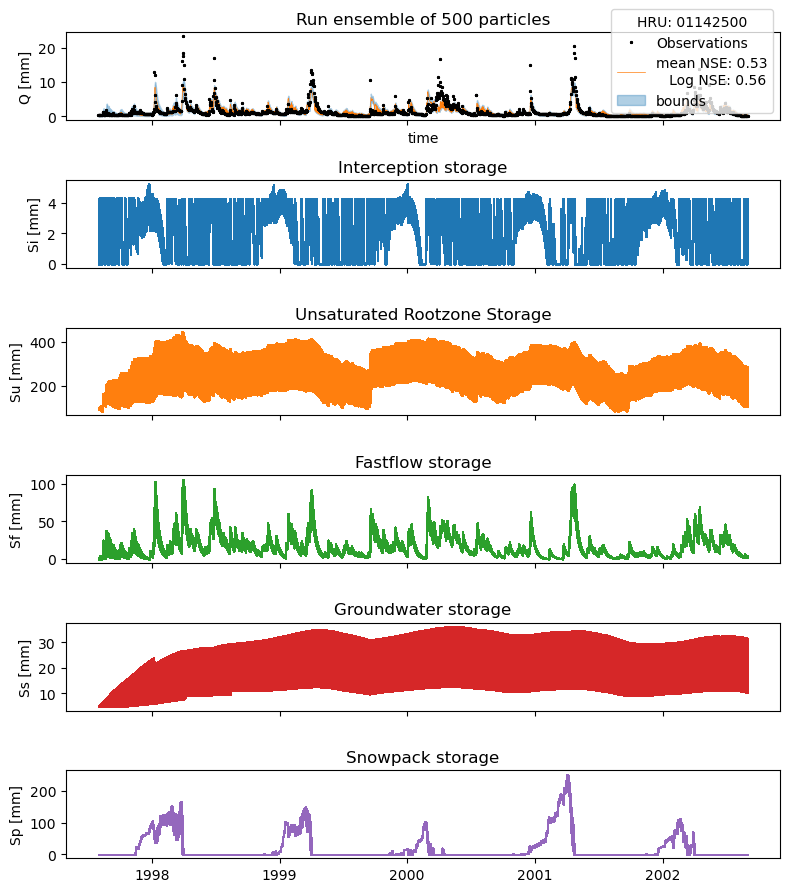

In [59]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 7

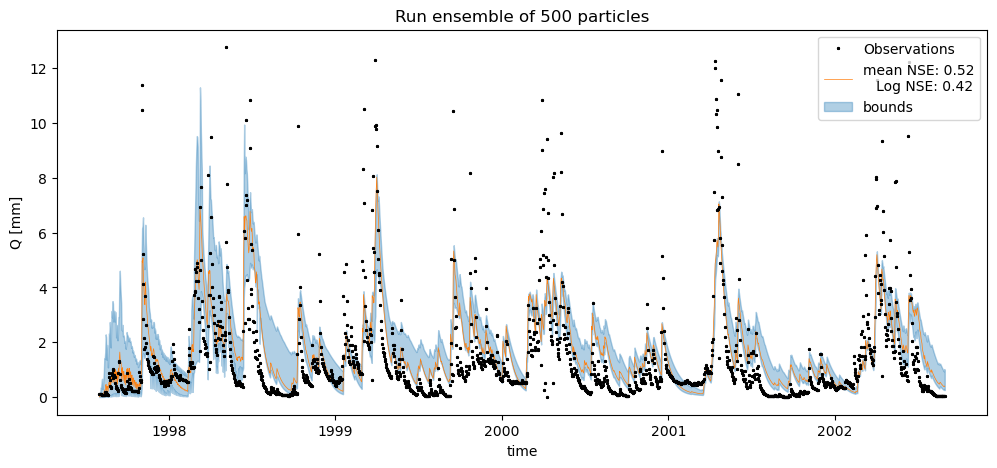

In [60]:
i=7
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

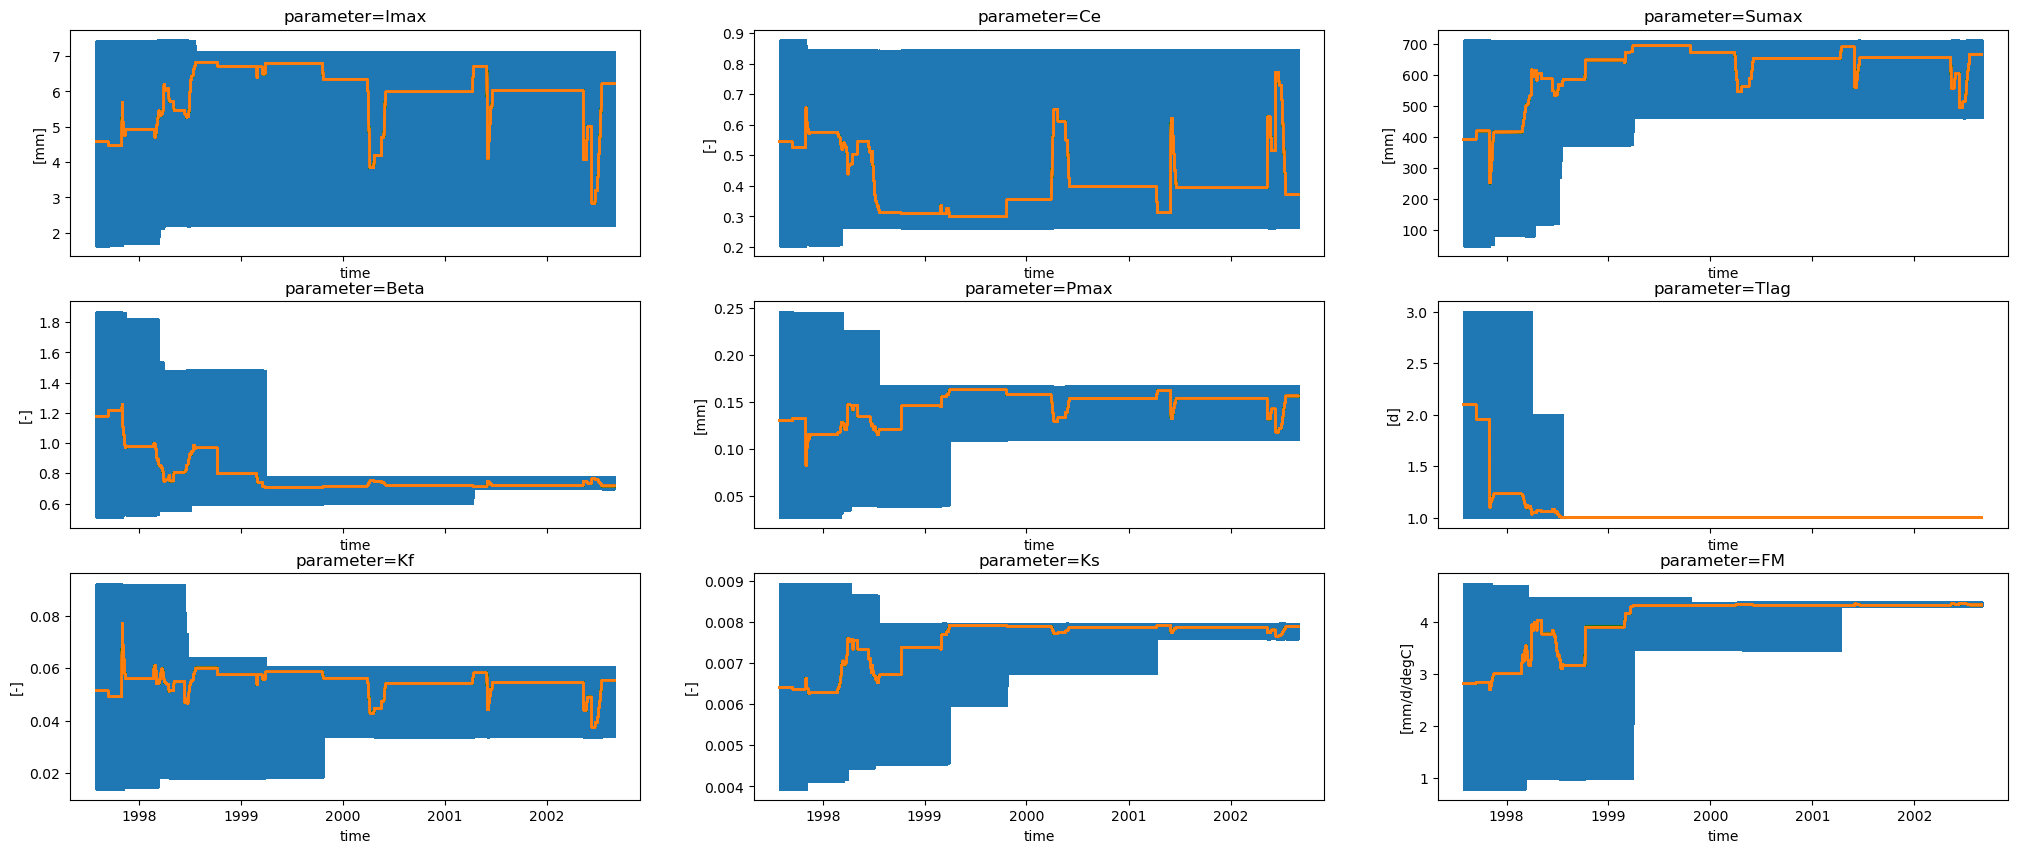

In [61]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

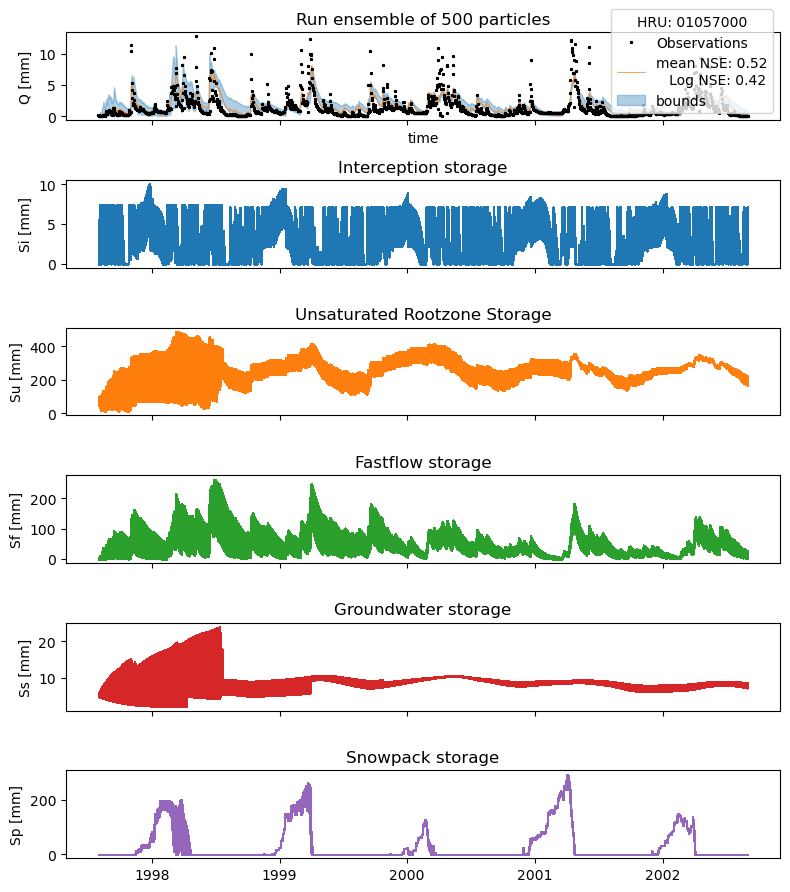

In [62]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 8

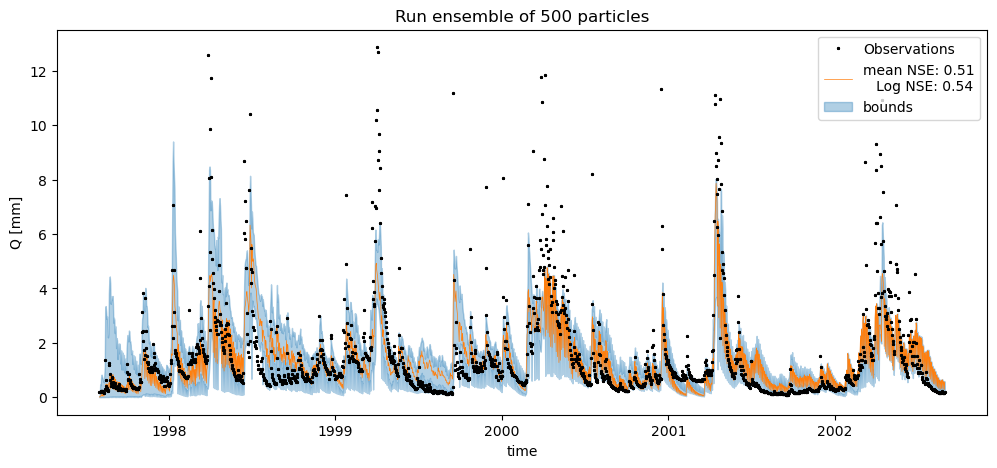

In [63]:
i=8
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

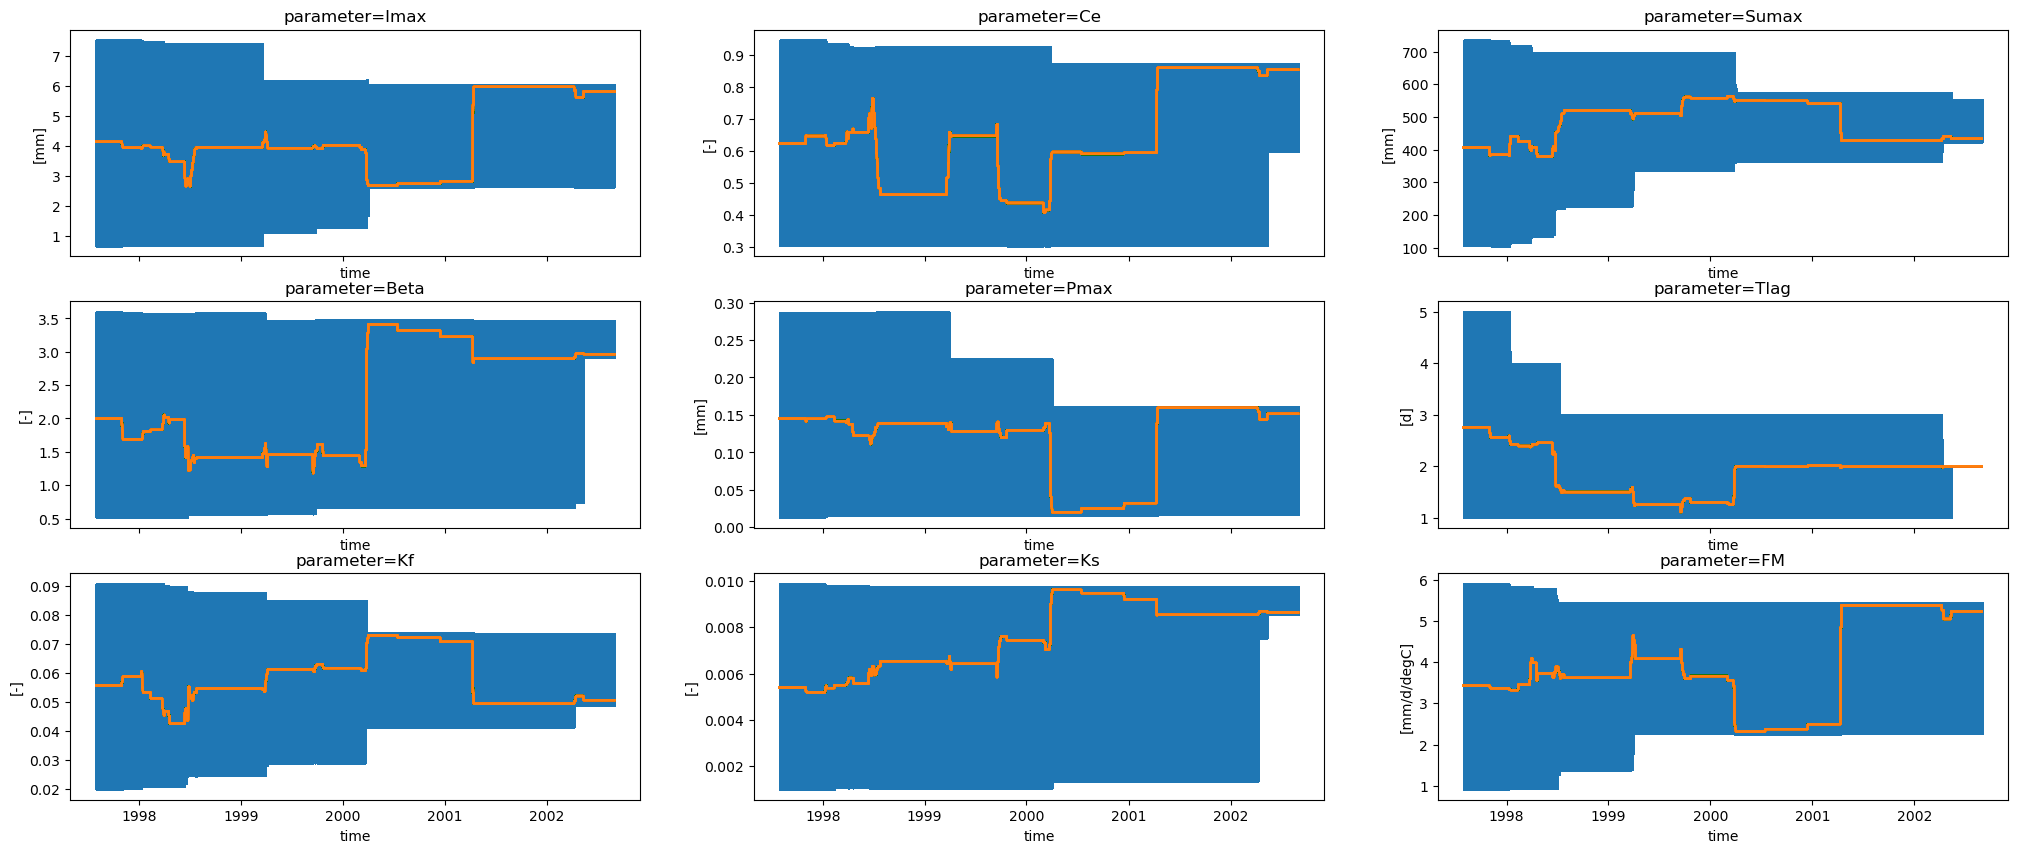

In [64]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

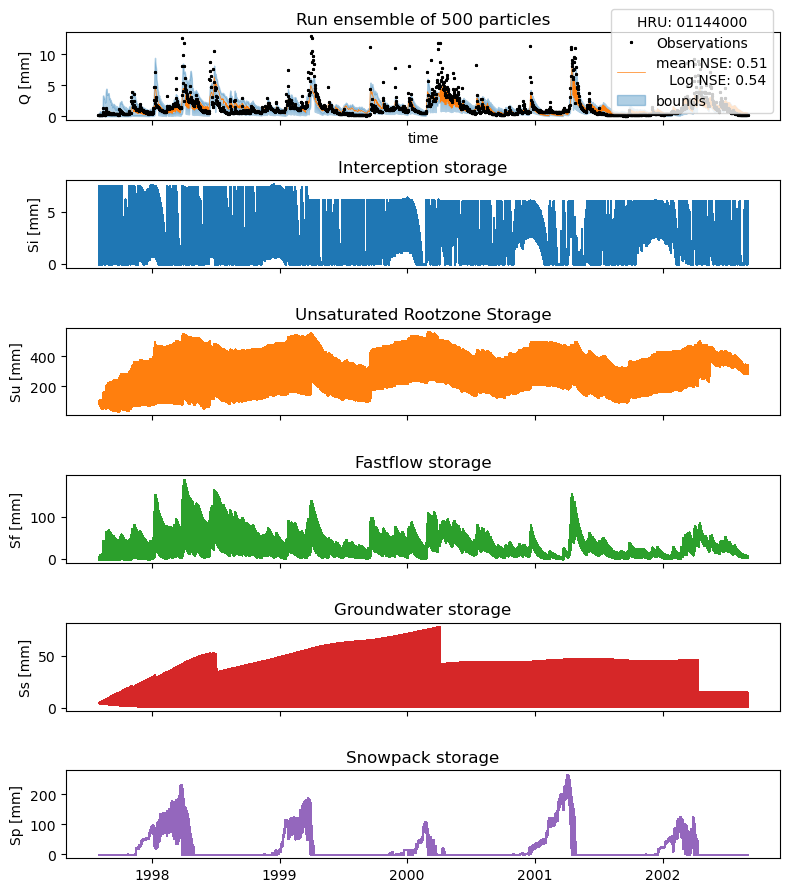

In [65]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 9

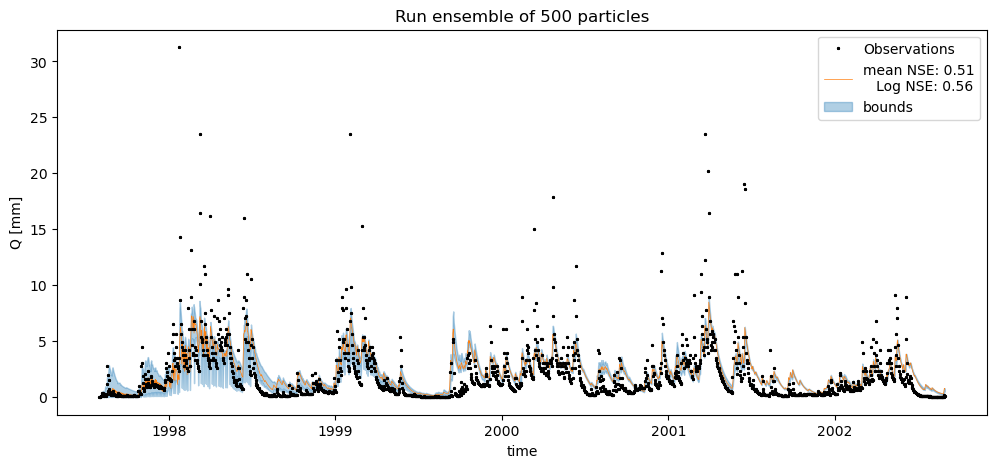

In [66]:
i=9
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

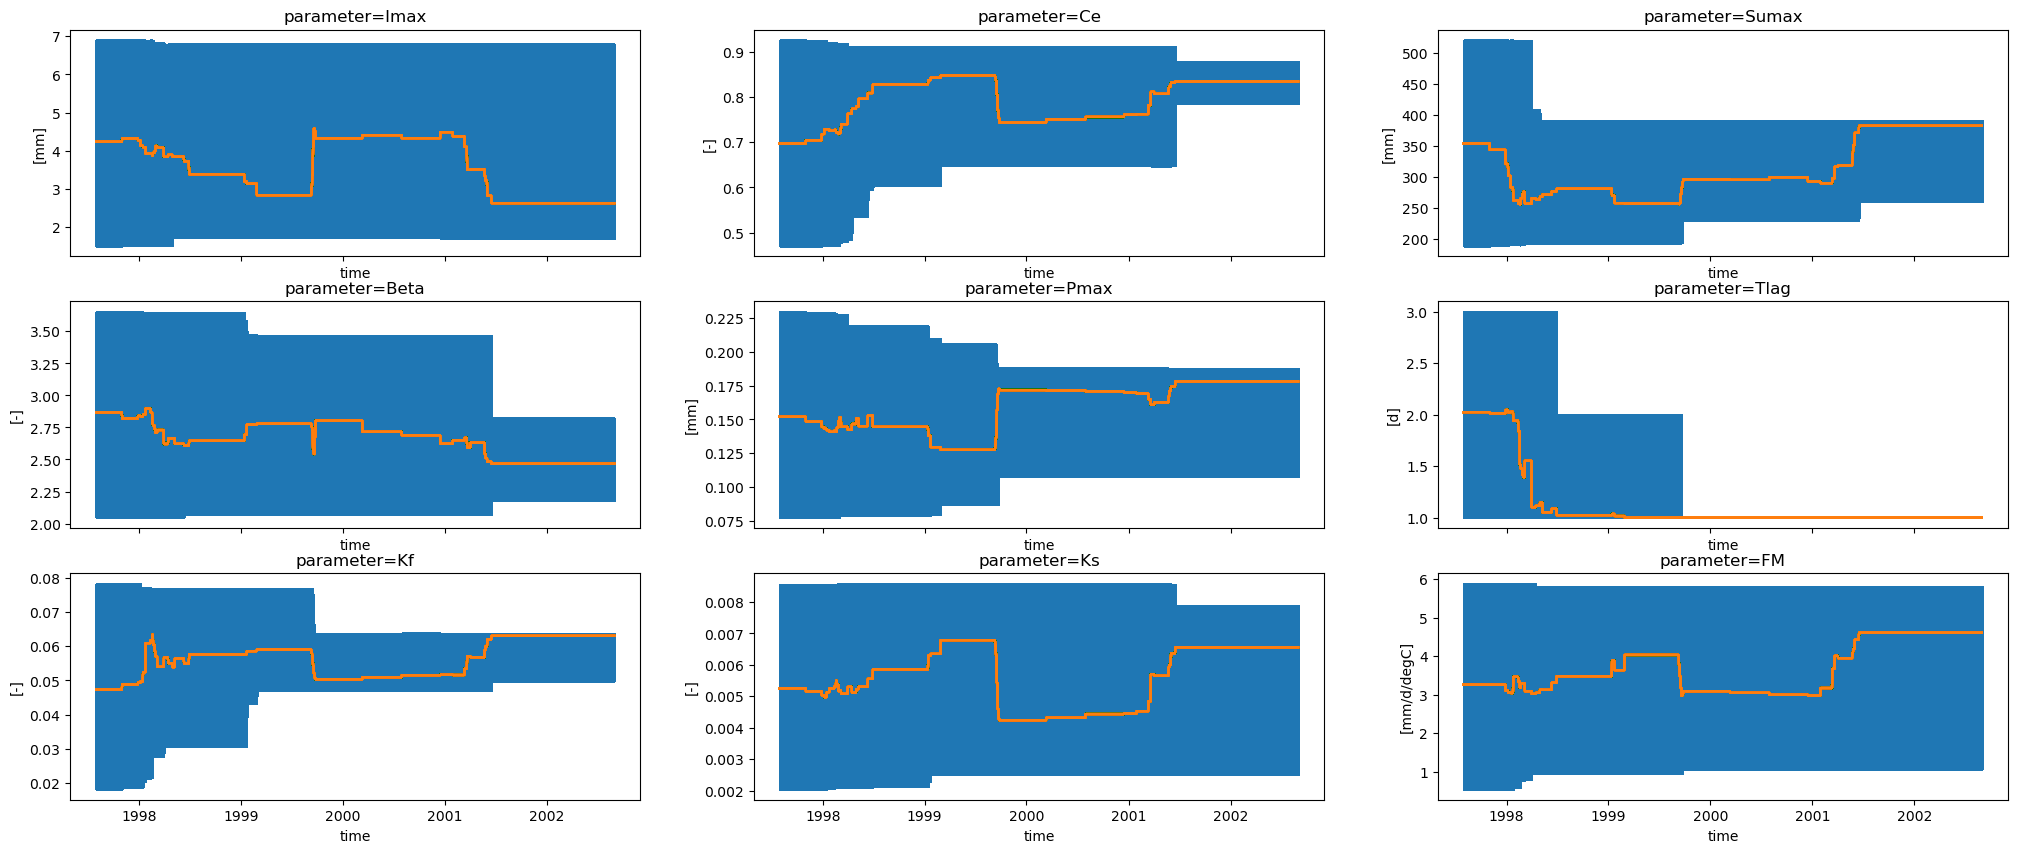

In [67]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

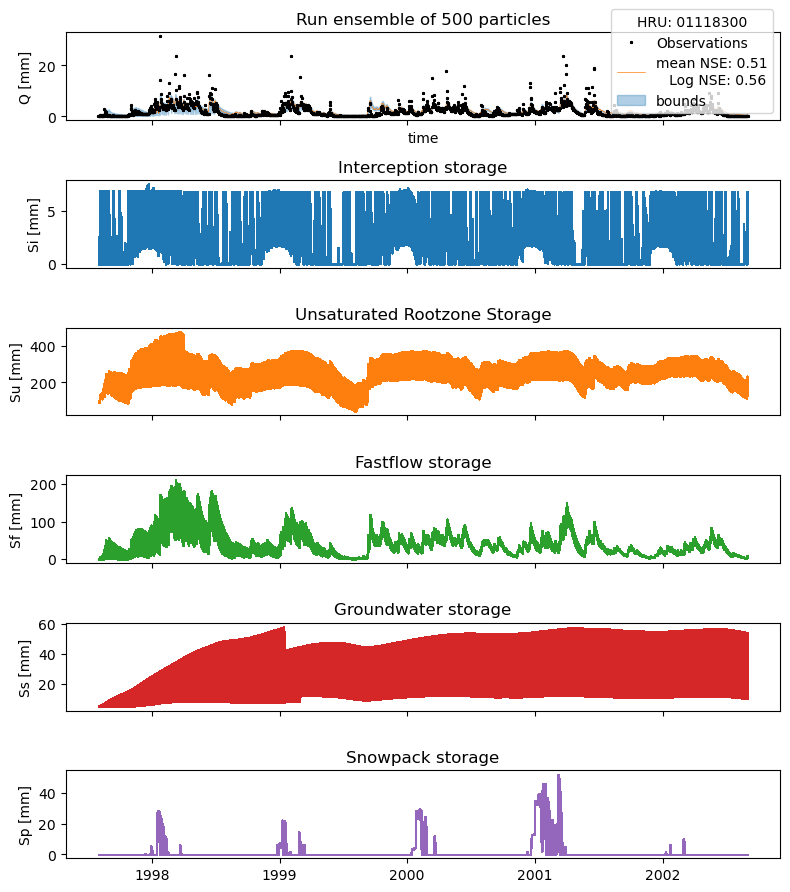

In [68]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 10

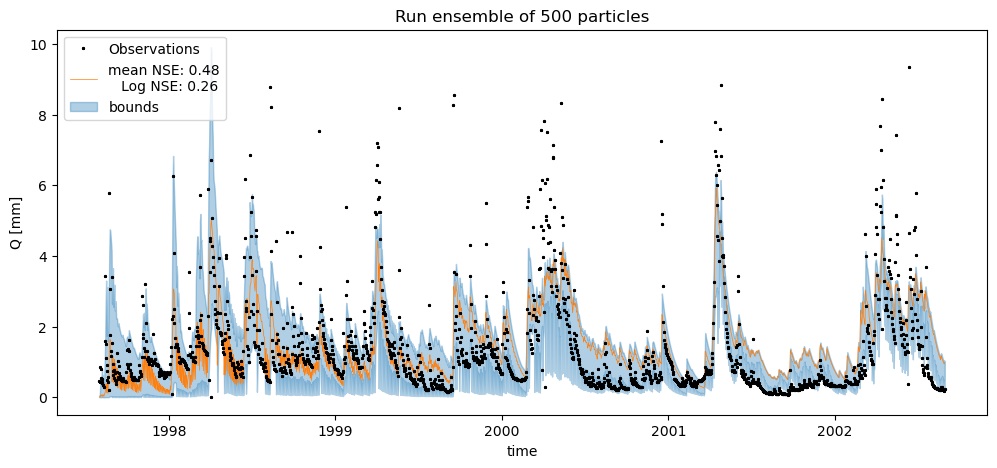

In [69]:
i=10
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

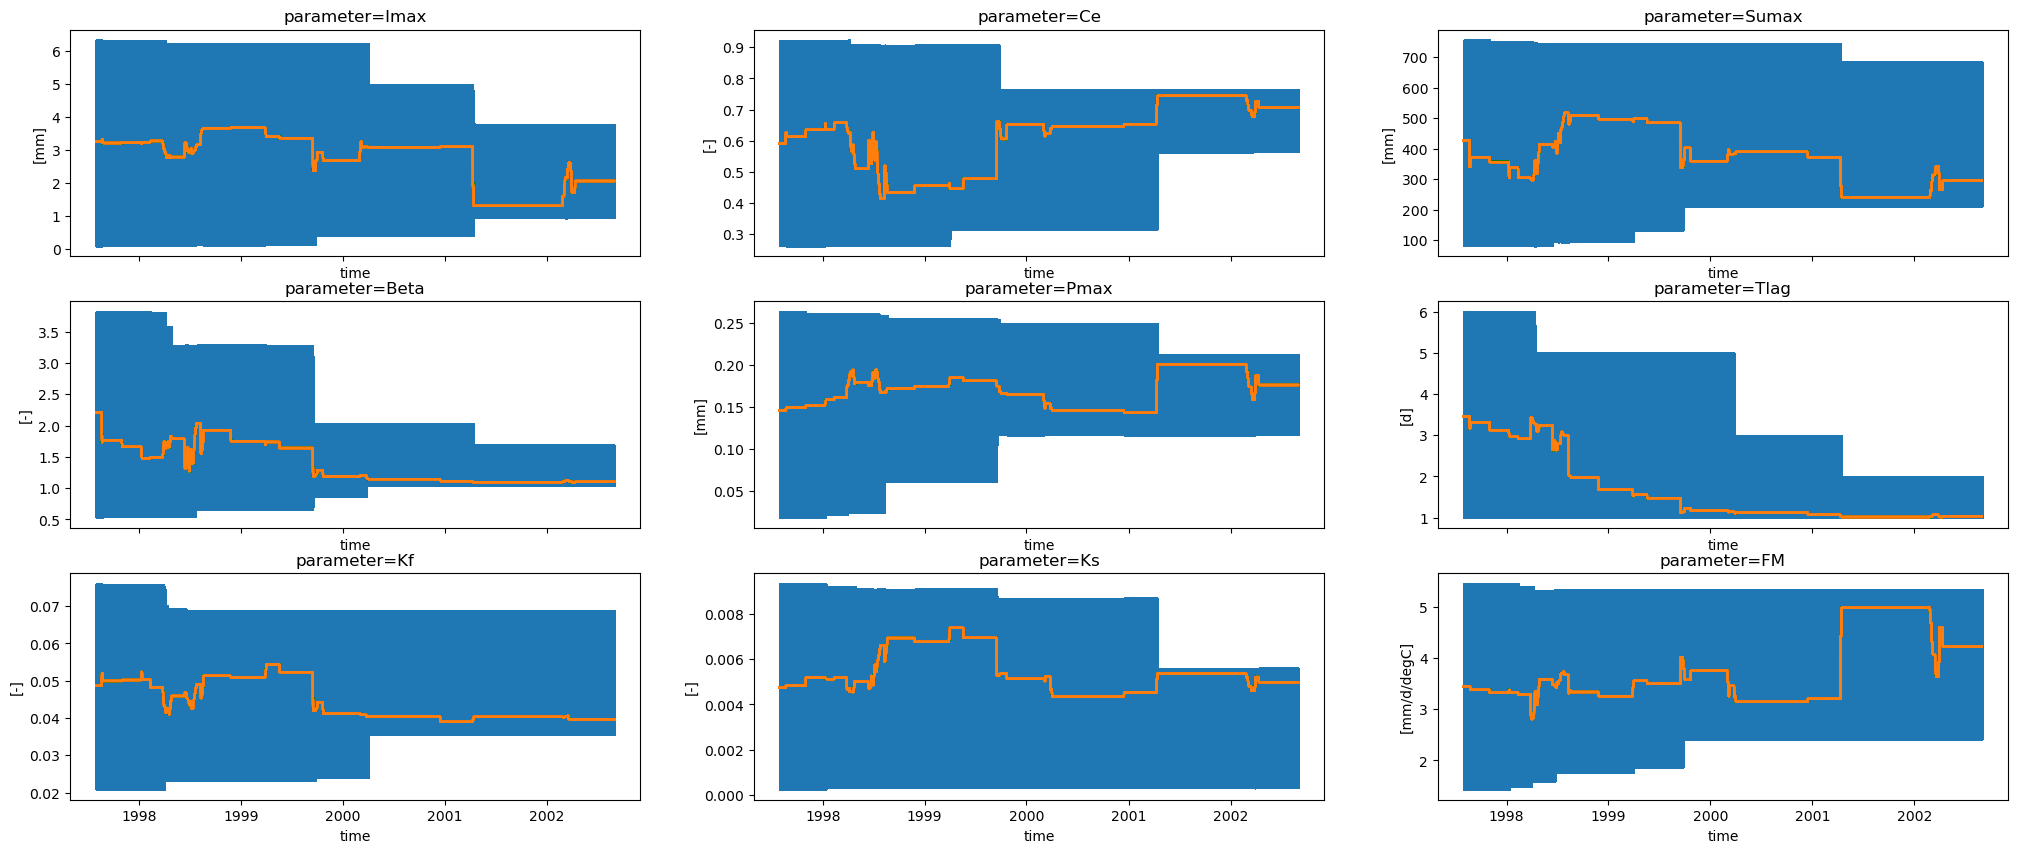

In [70]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

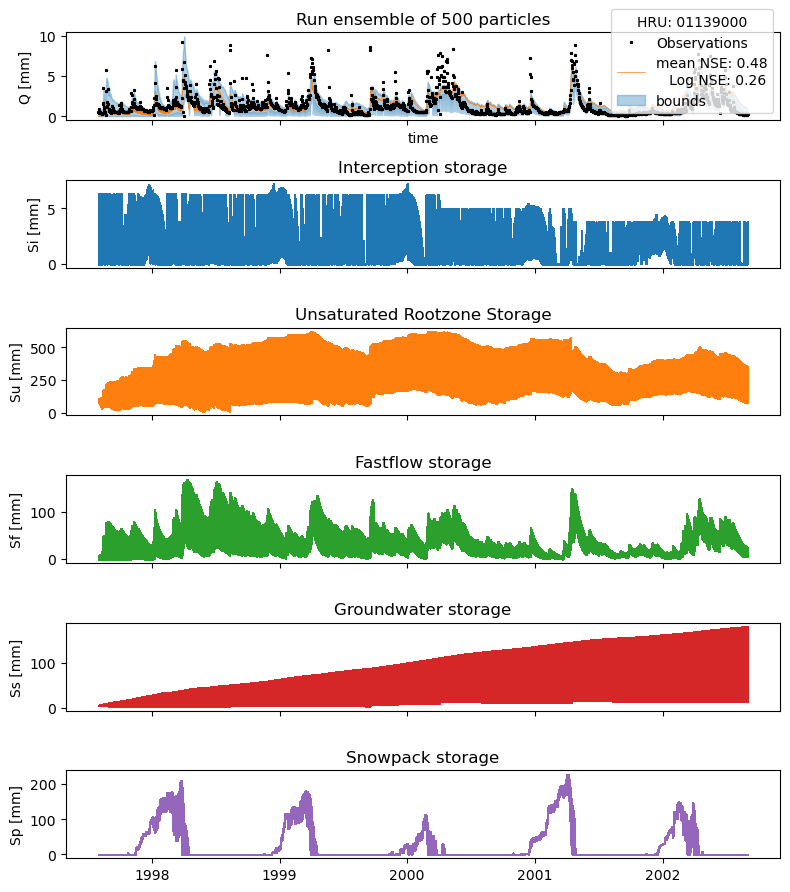

In [71]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 11

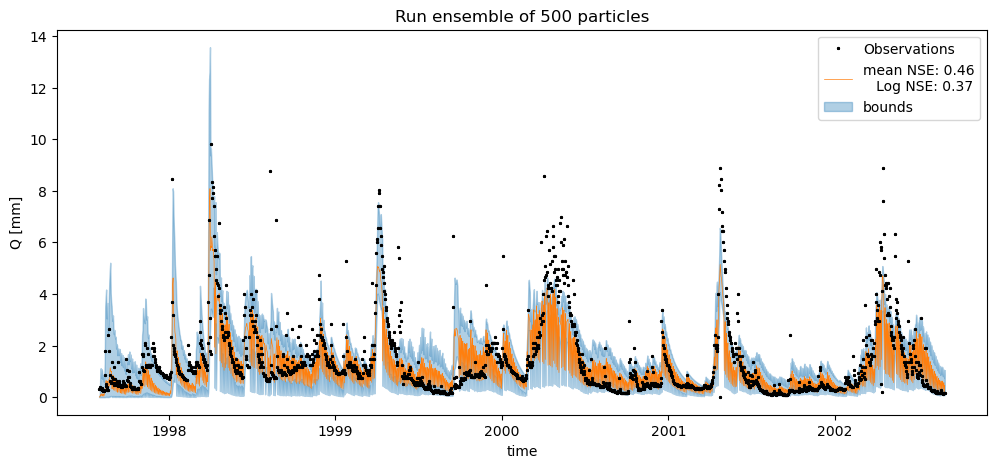

In [72]:
i=11
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

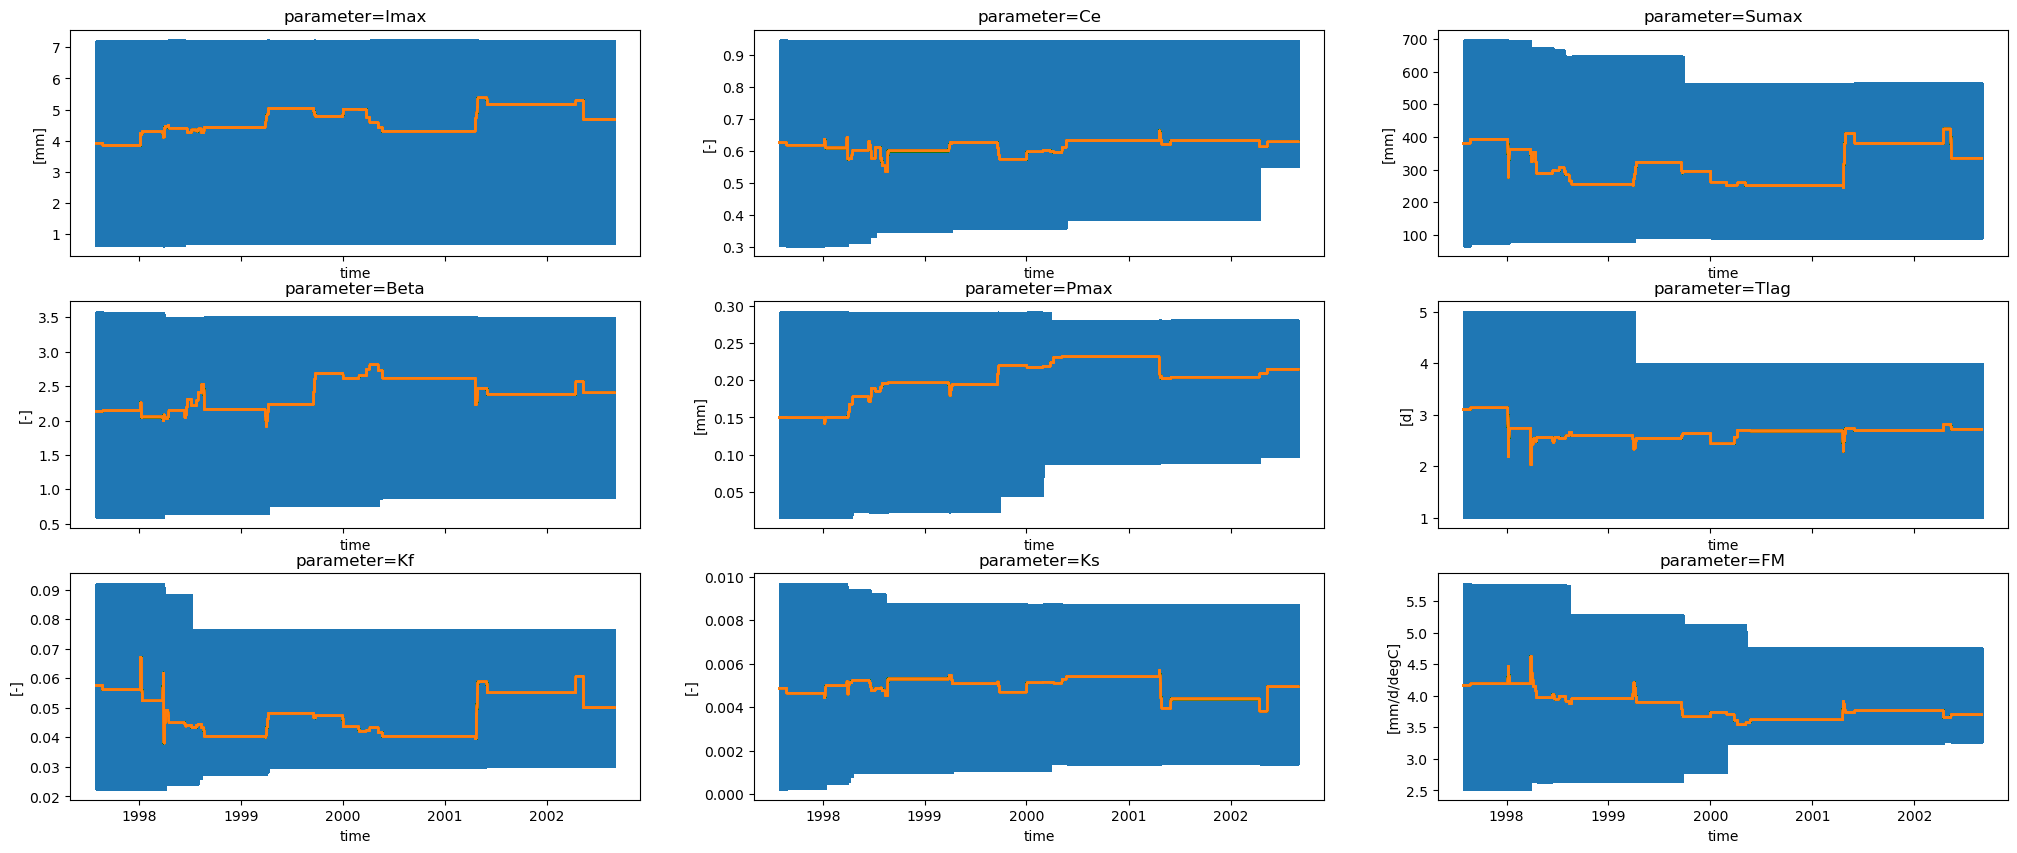

In [73]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

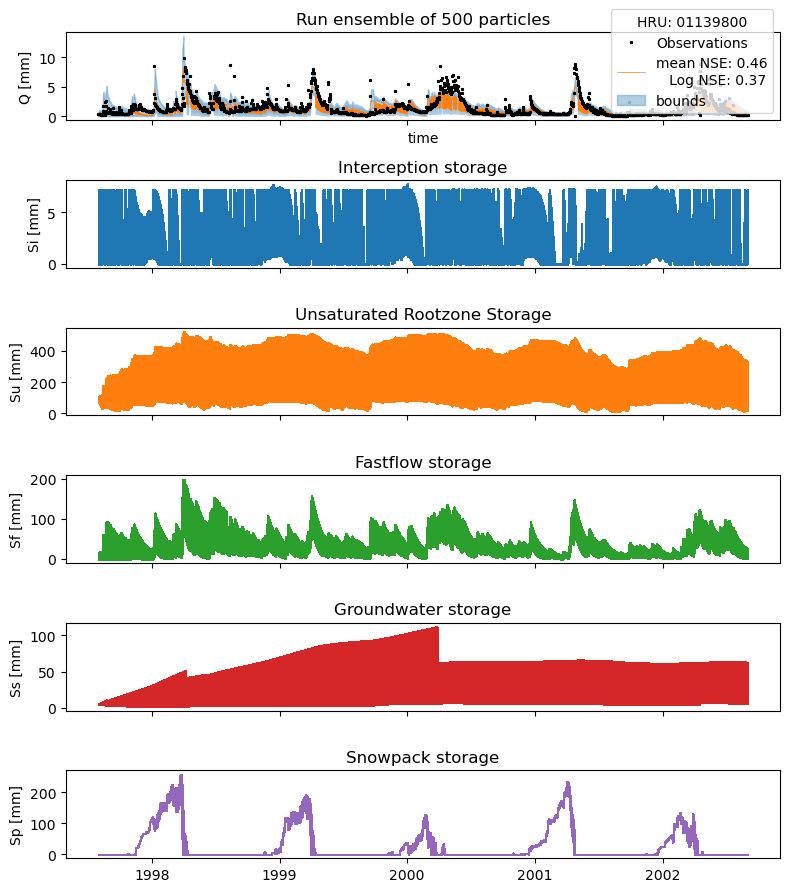

In [74]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 12

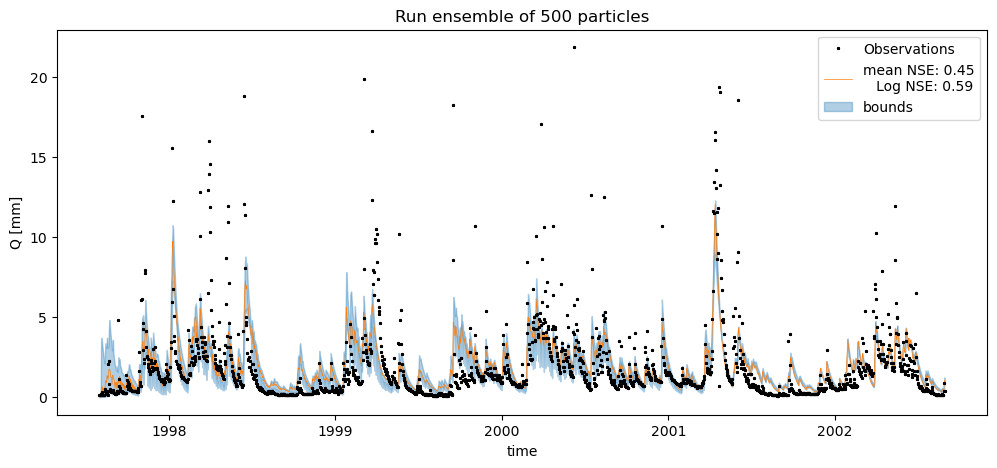

In [75]:
i=12
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

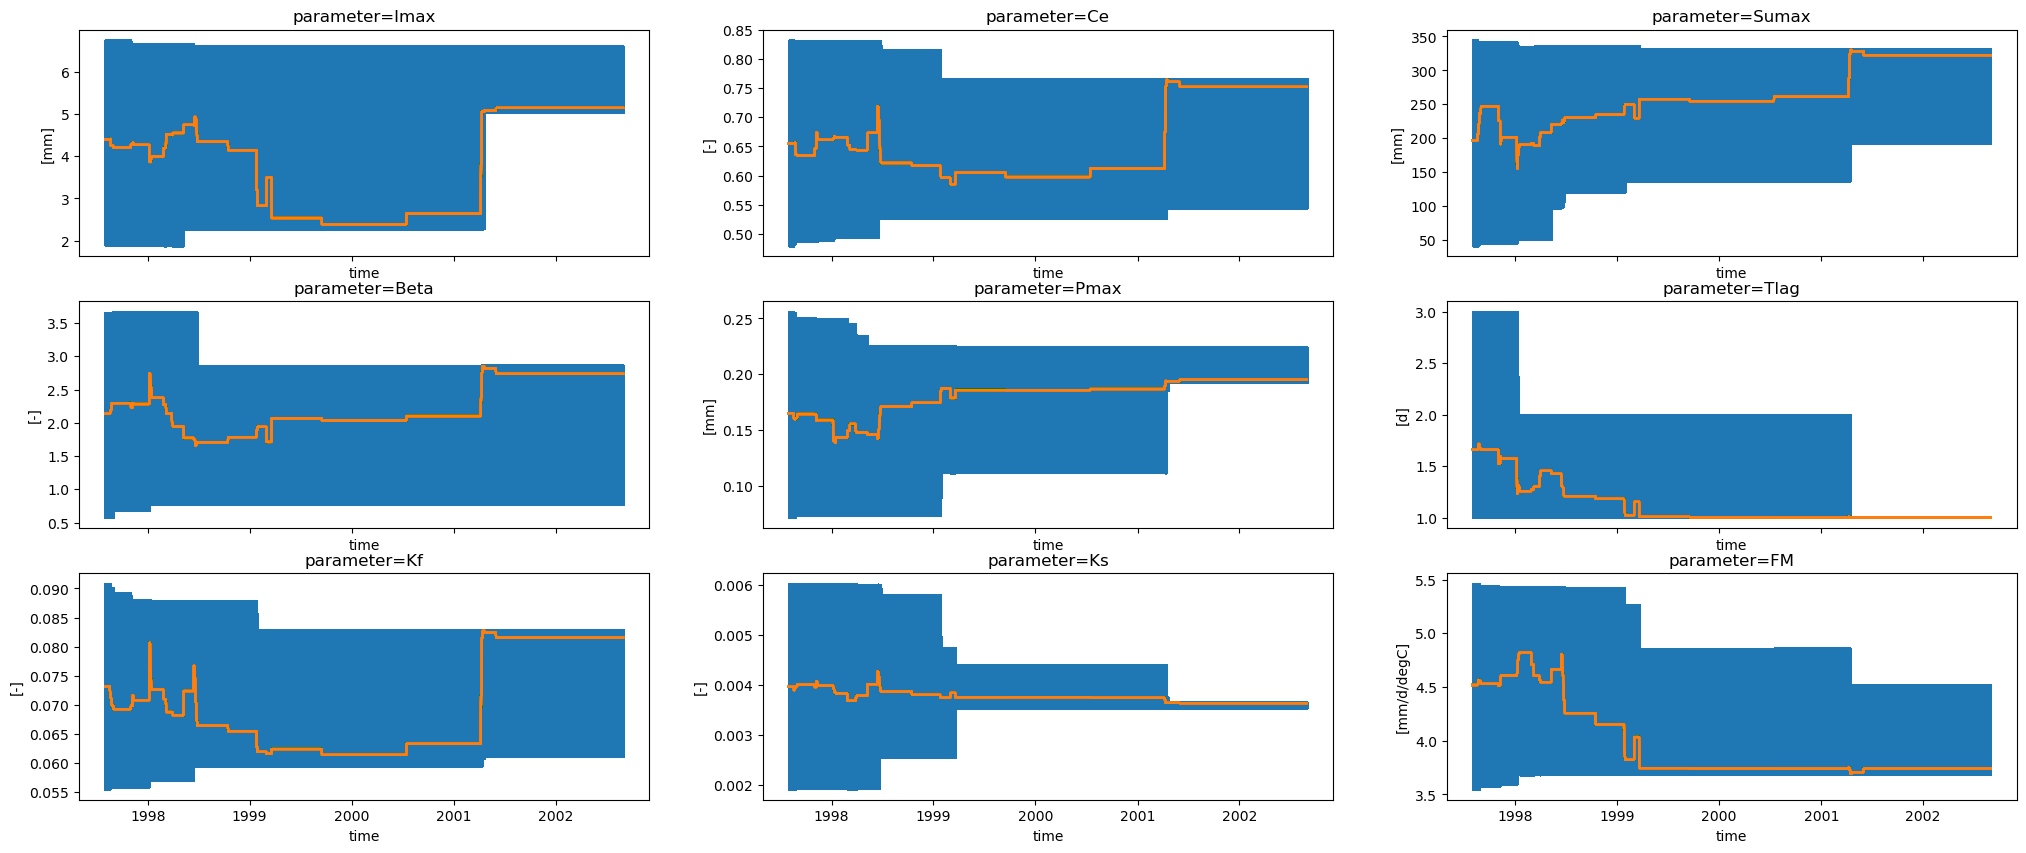

In [76]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

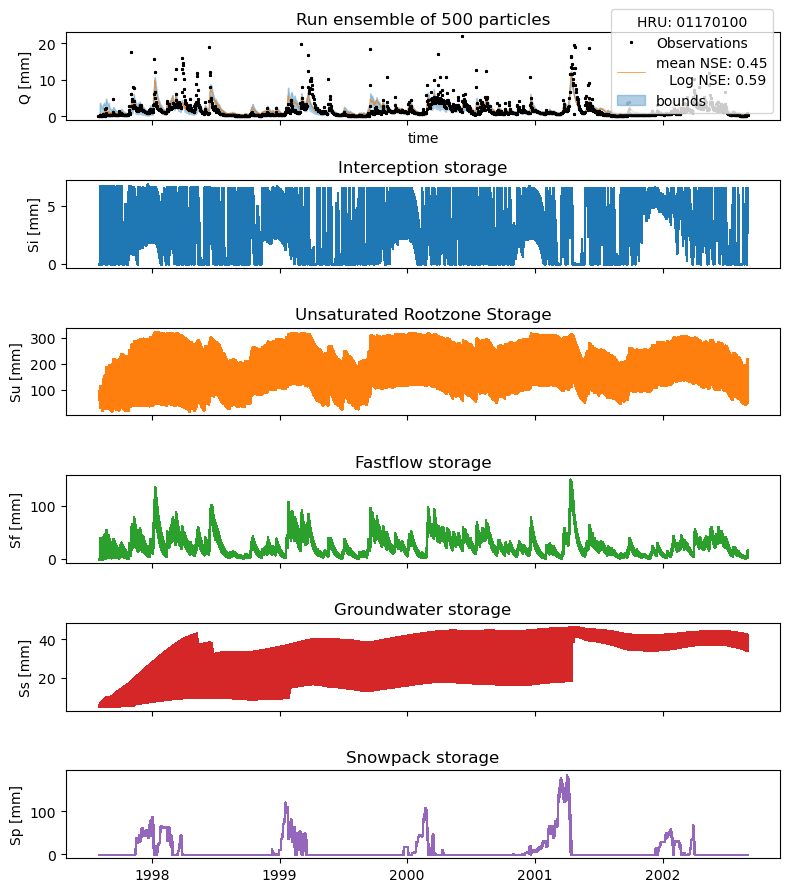

In [77]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 13

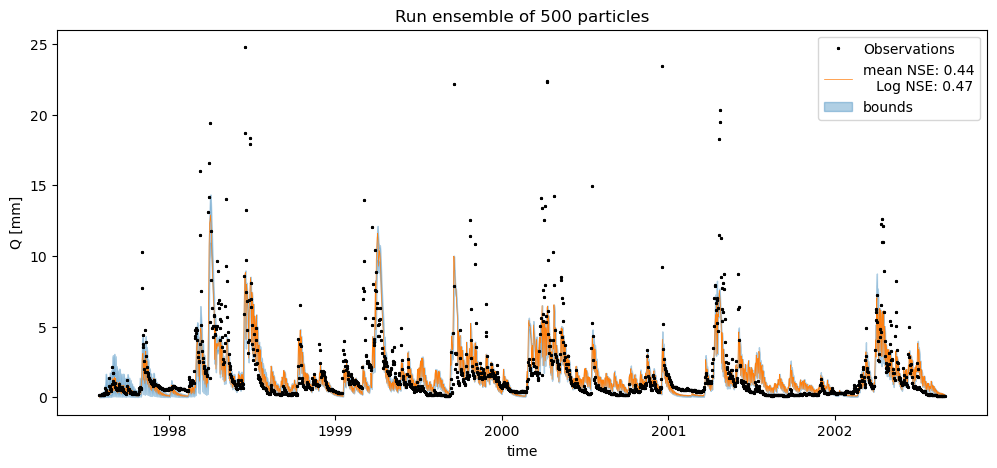

In [78]:
i=13
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

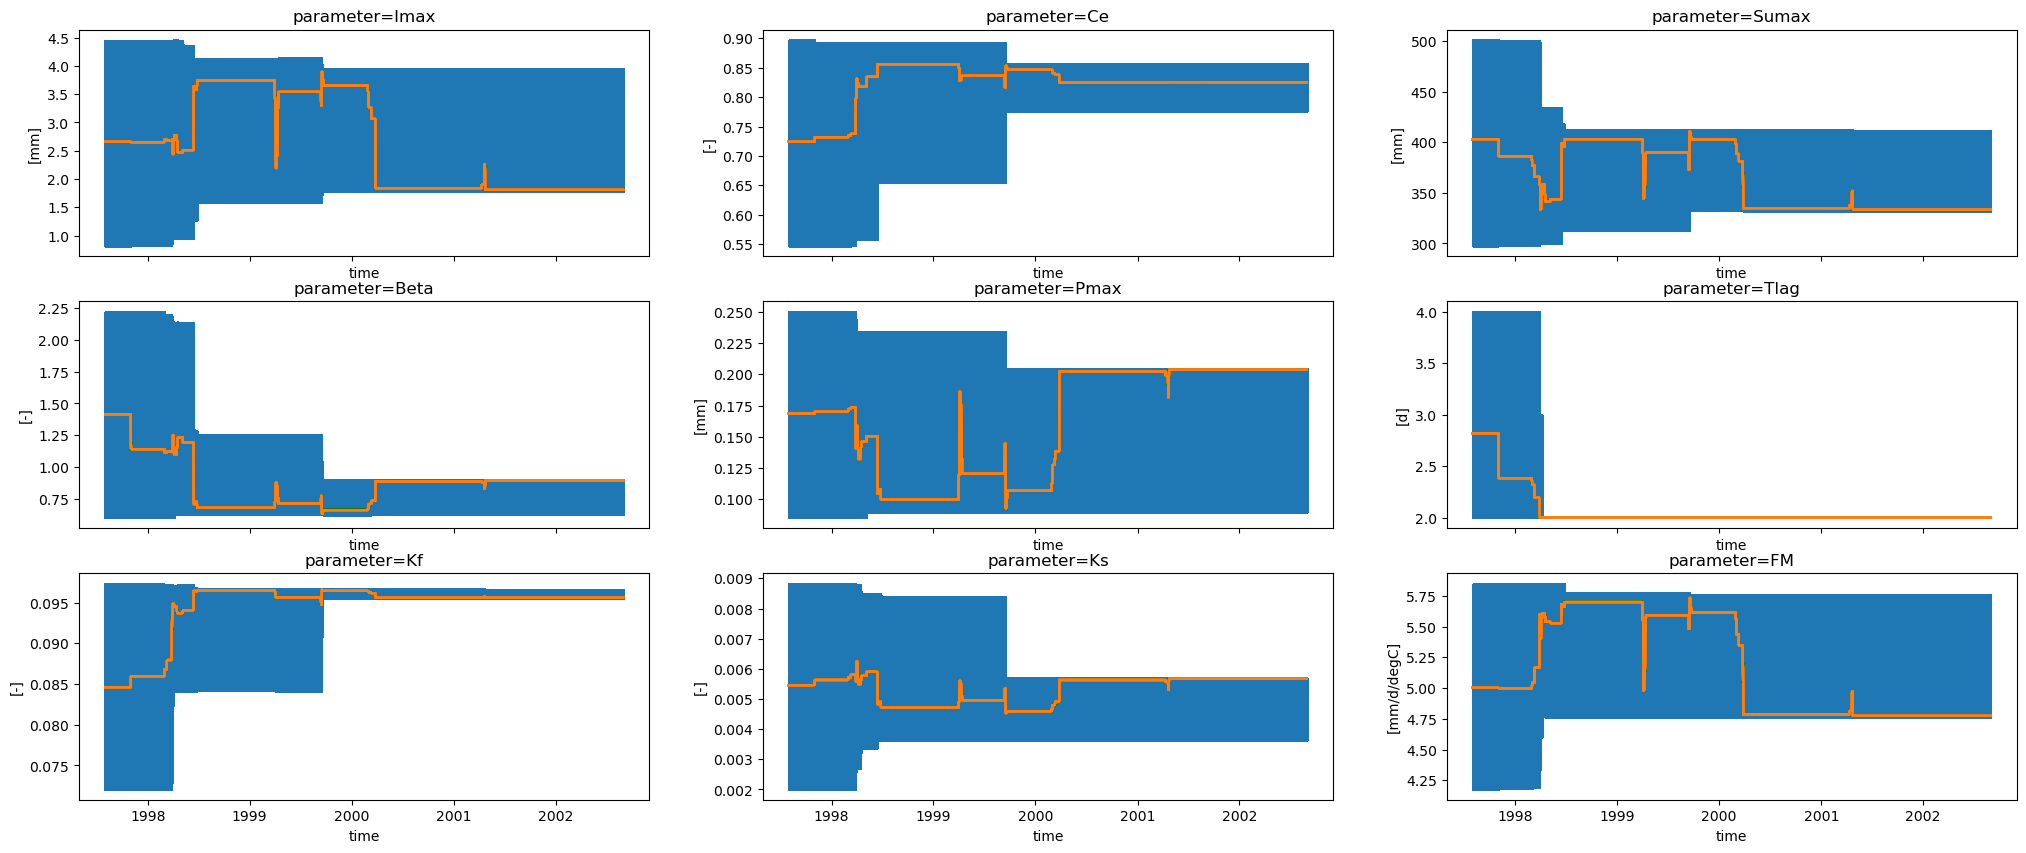

In [79]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

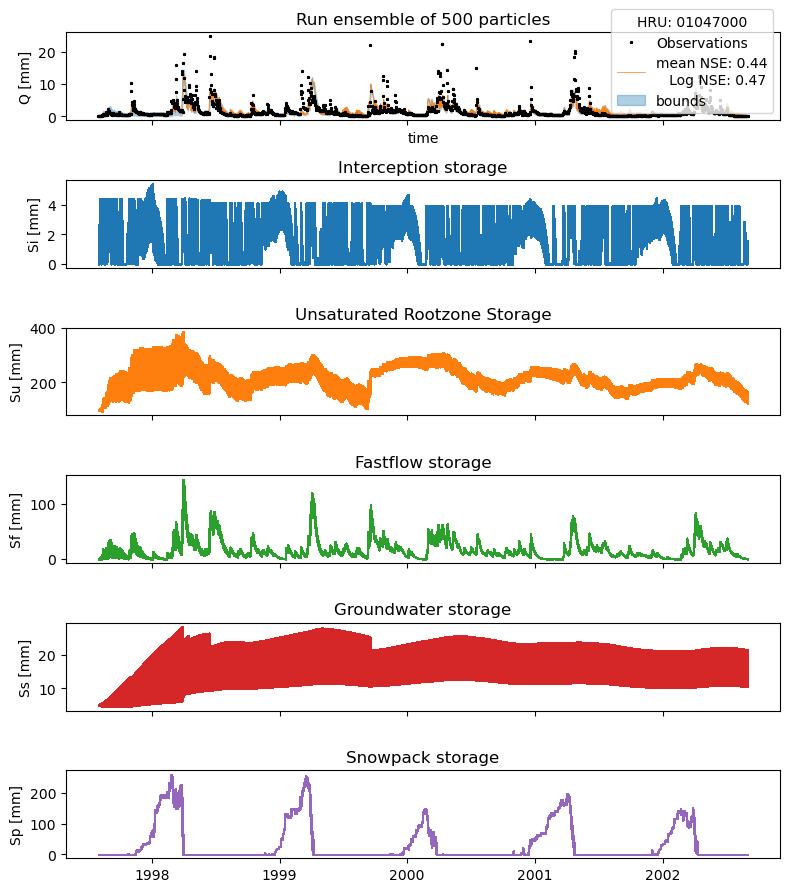

In [80]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 14

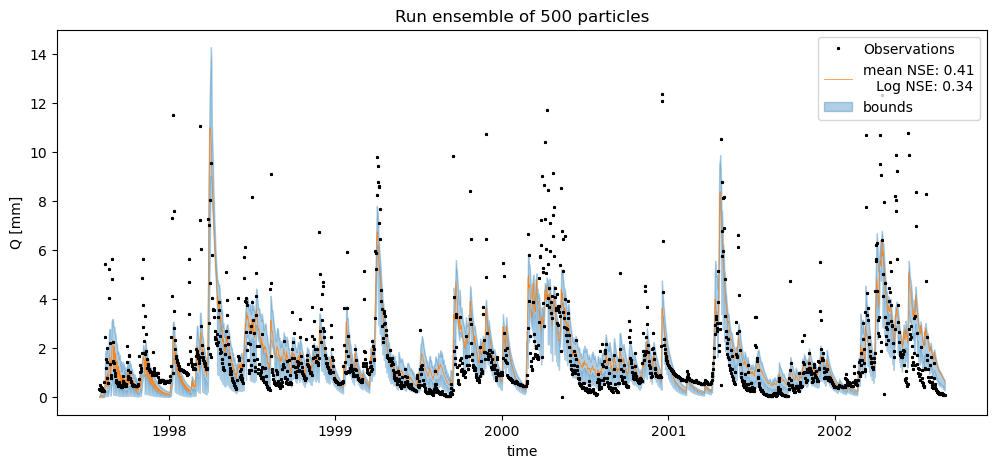

In [82]:
i=14
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

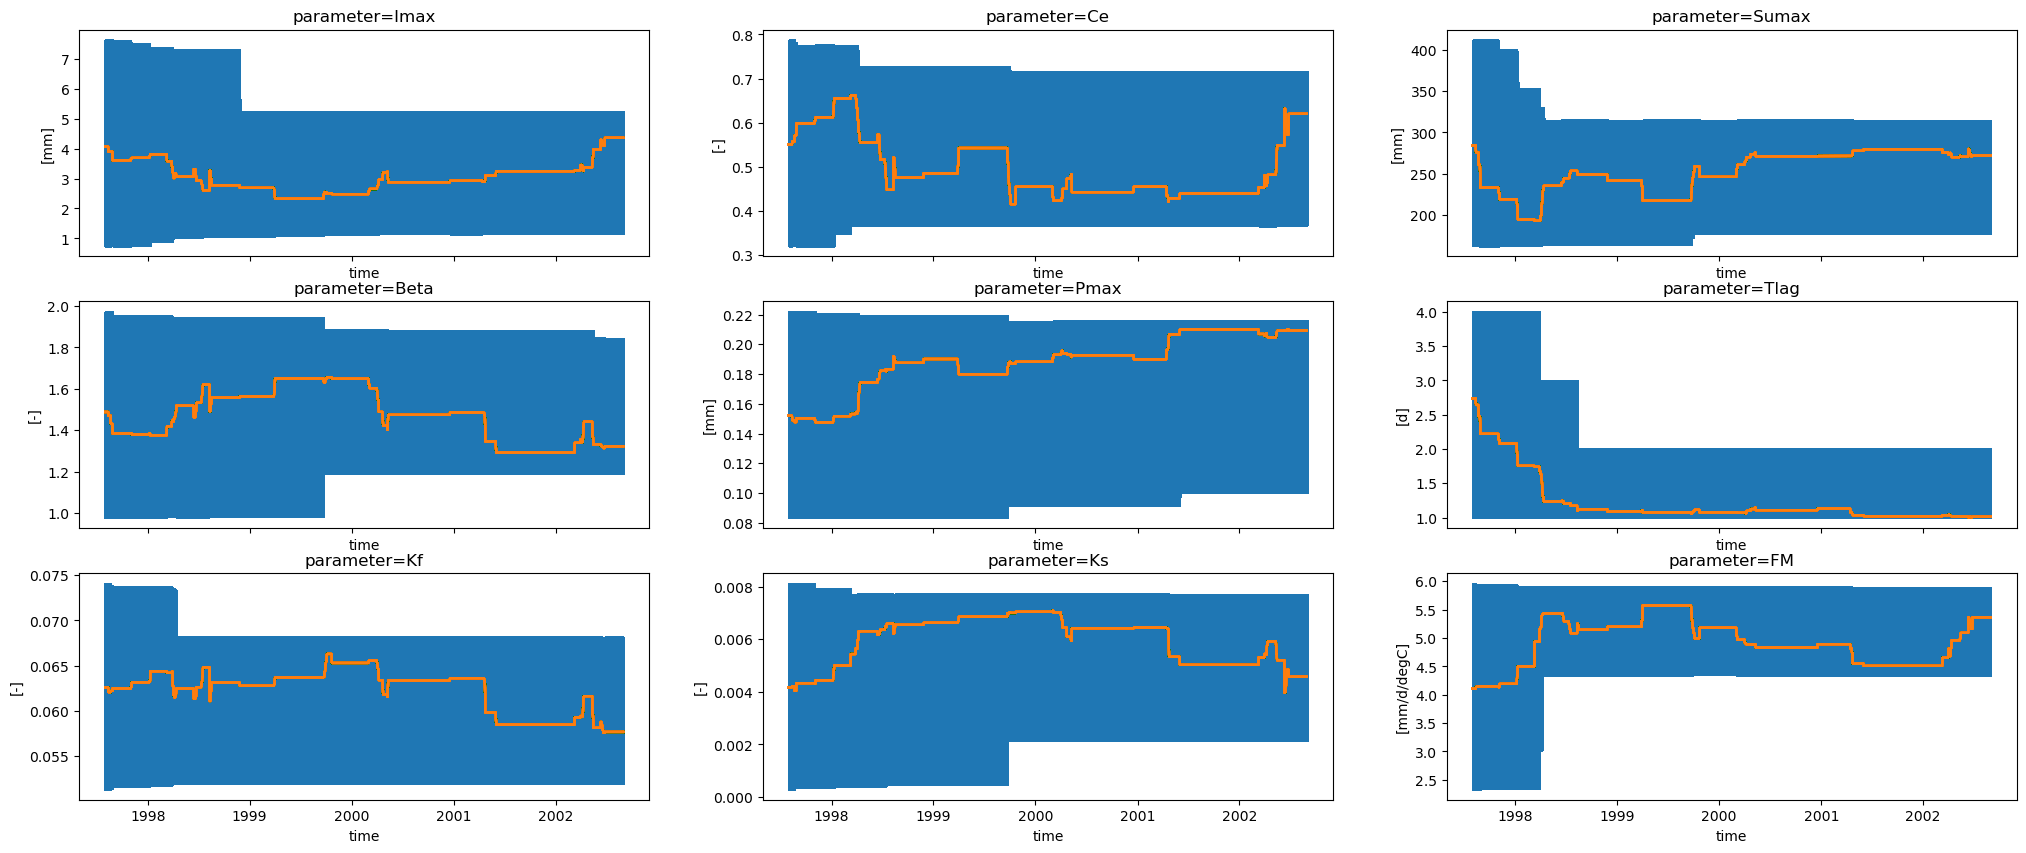

In [83]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

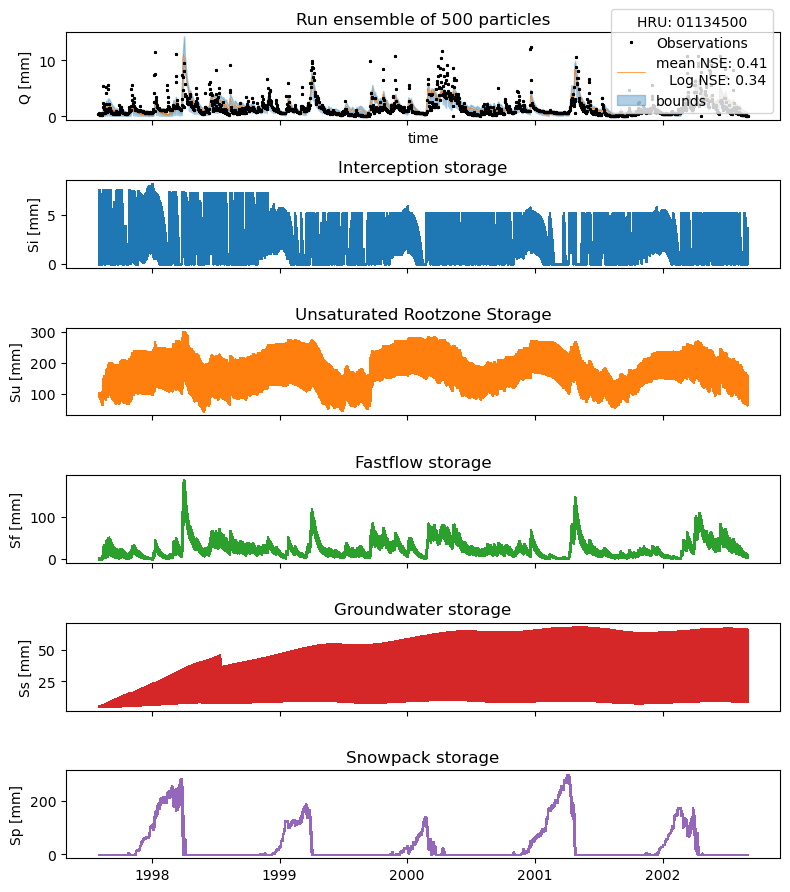

In [84]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 15

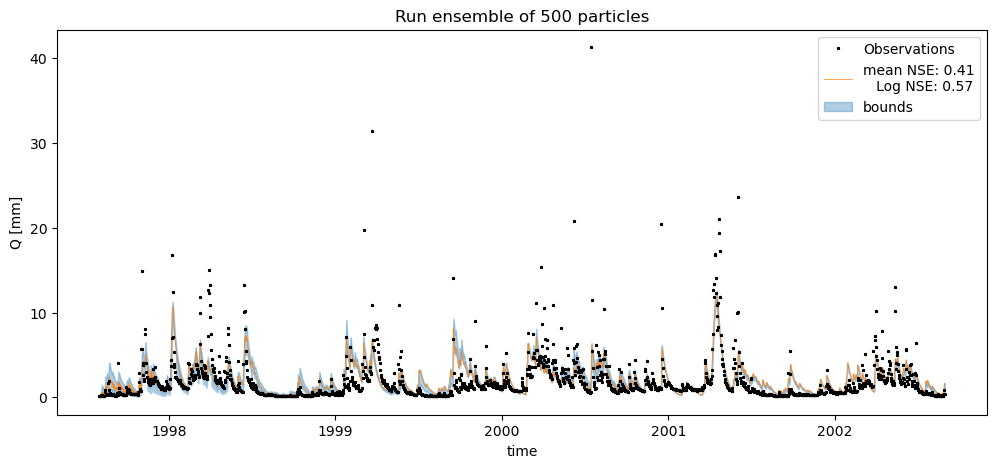

In [85]:
i=15
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

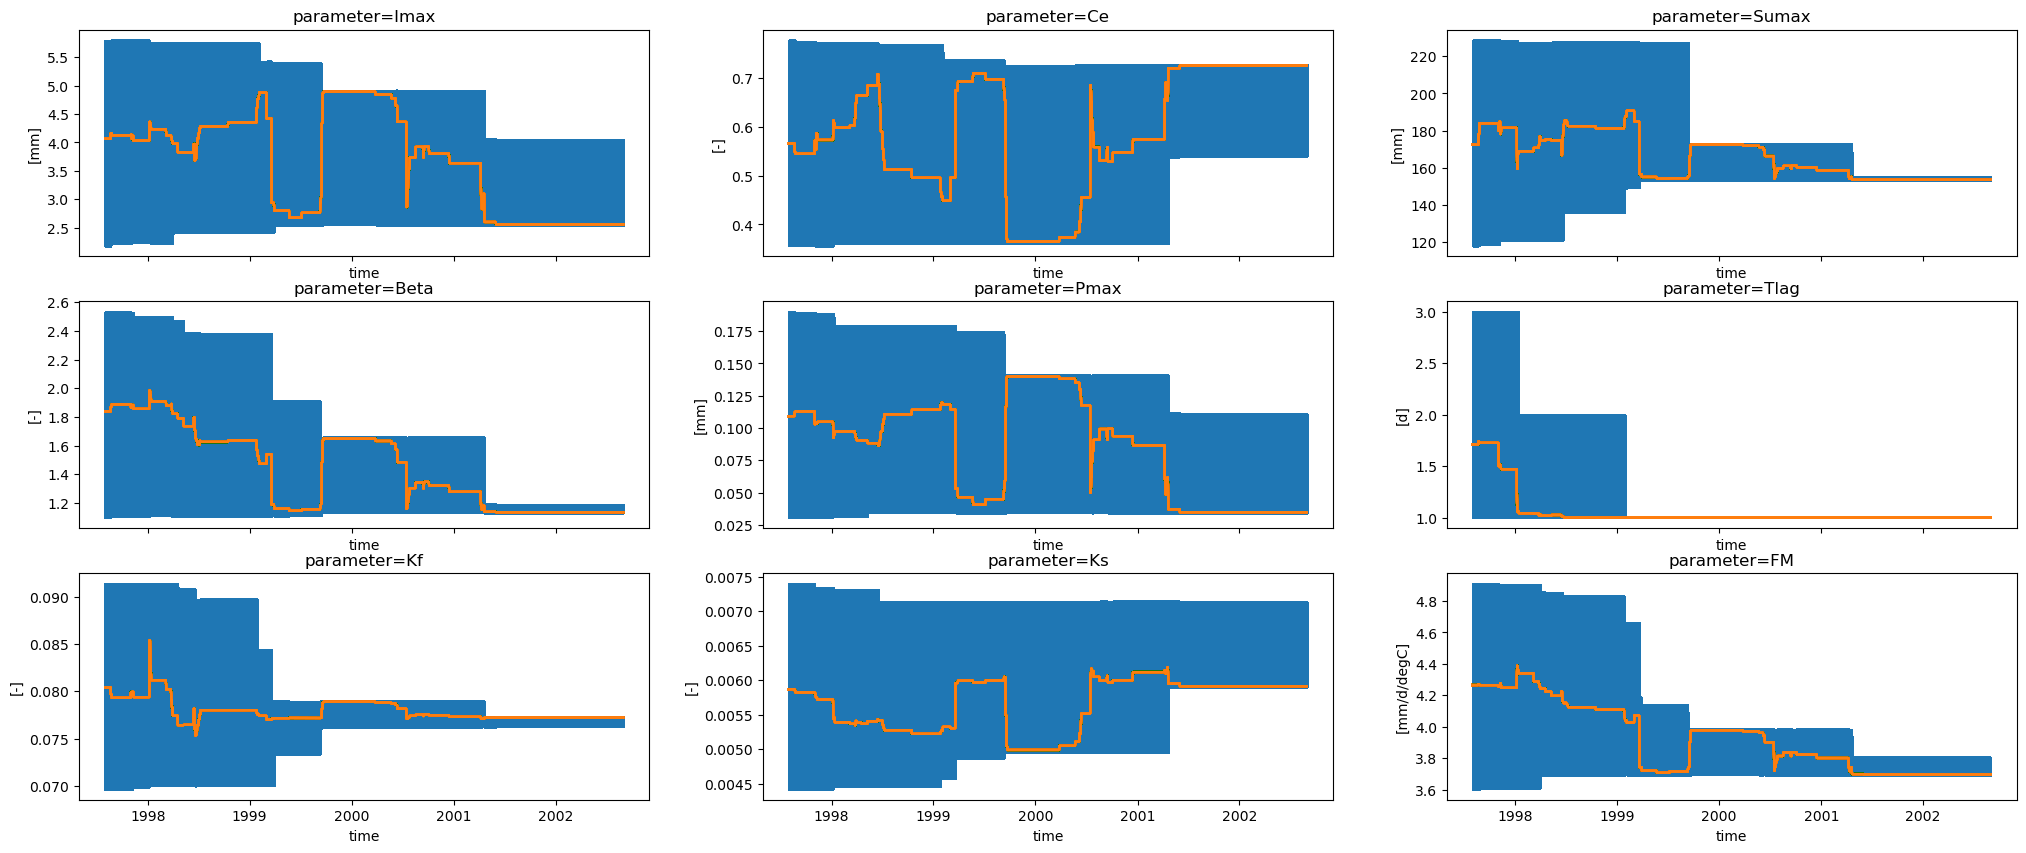

In [86]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

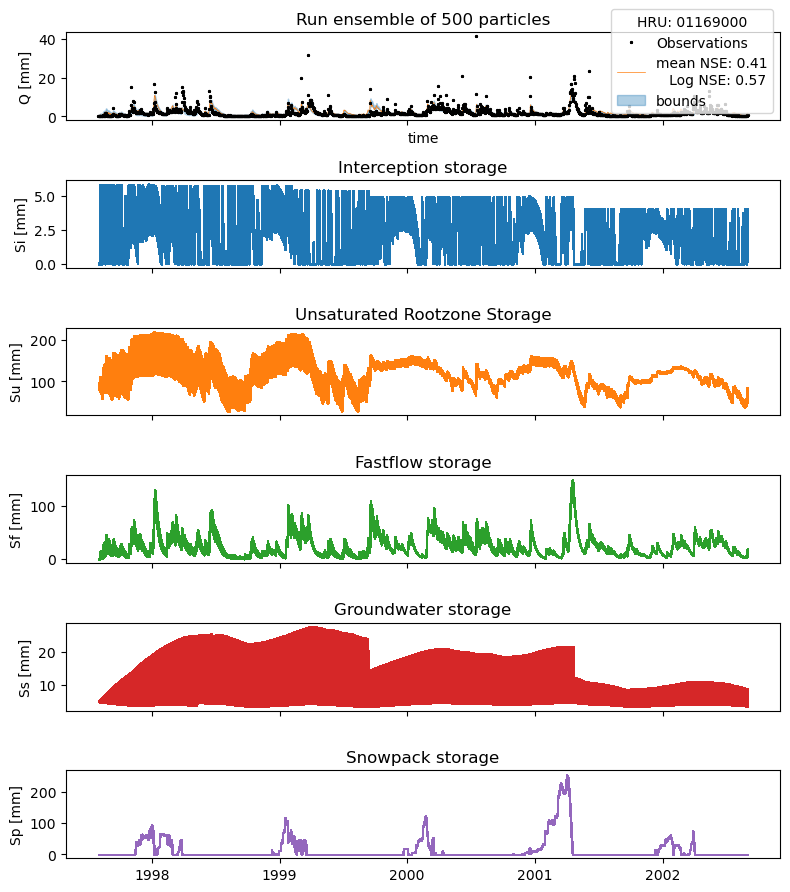

In [87]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 16

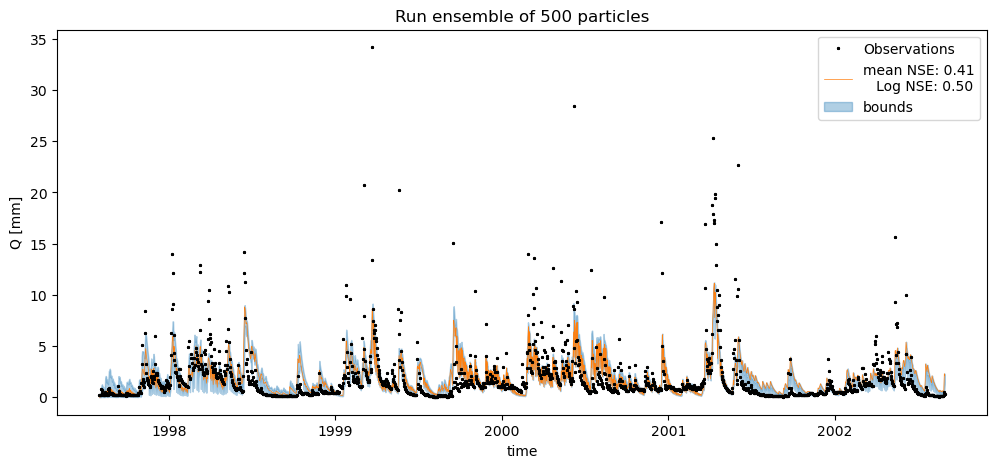

In [88]:
i=16
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

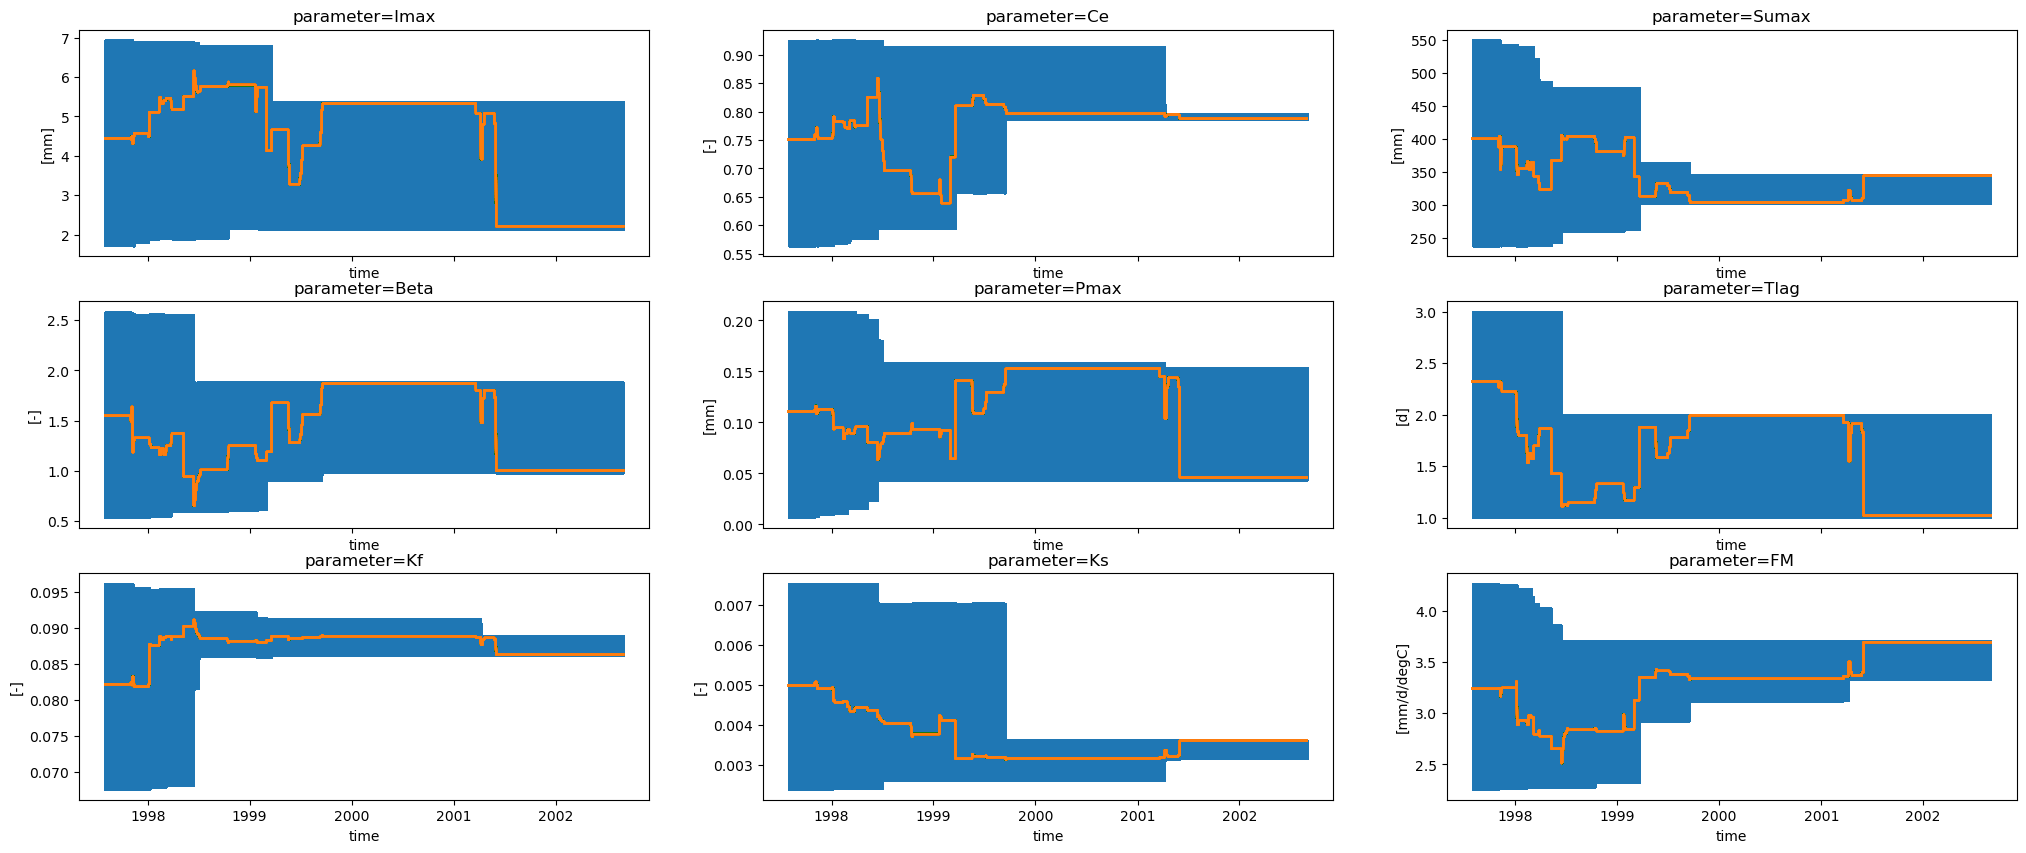

In [89]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

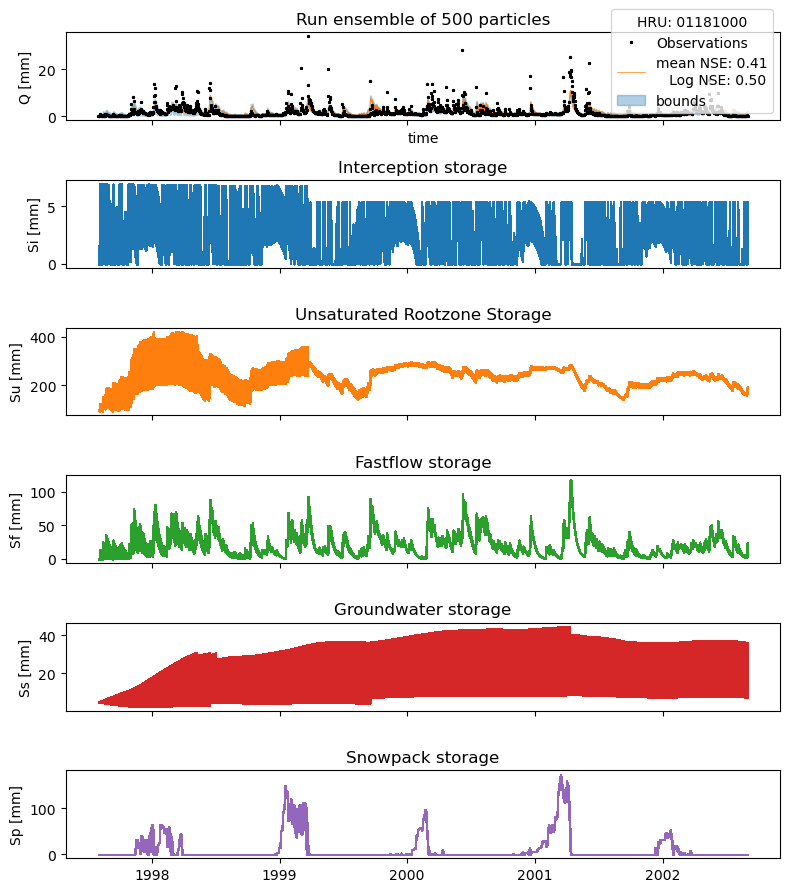

In [90]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)